In [33]:
import pandas as pd
from glob import glob
from collections import namedtuple, deque
import math
import itertools
import functools
from functools import reduce
from itertools import product, groupby, combinations, permutations
import numpy as np
from scipy.interpolate import UnivariateSpline
import cv2
import random
from skimage import io, morphology, img_as_bool, transform, img_as_ubyte, img_as_float, exposure, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from skimage.measure import label, regionprops
from skimage.transform import probabilistic_hough_line
from scipy import stats
import copy
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from scipy import io as sio
from ridge_detection.lineDetector import LineDetector
from ridge_detection.params import Params,load_json
from ridge_detection.basicGeometry import reset_counter
from ridge_detection.helper import displayContours,save_to_disk
from PIL import Image
from tqdm import tqdm

In [118]:
def smooth_mask(mask, smooth_sigma=3):
    mask = img_as_float(mask)
    mask = exposure.rescale_intensity(mask, out_range=(0, 1))
    density = exposure.rescale_intensity(filters.gaussian(  mask,
                                                            # morphology.dilation(mask, 
                                                            # footprint=morphology.disk(1)), 
                                                            sigma=smooth_sigma, 
                                                            preserve_range=False), 
                                        out_range=(0, 1))
    return density

def norm_counts(counts, weights, beta=0.1):
    """
        This function returns a set of normalized counts, based on the weights of bins
    """
    weights = [i+beta for i in weights] # smooth
    weights = [i/ min(weights) for i in weights]
    counts_norm = [list(itertools.repeat(count, int(weight*100)))  for count, weight in zip(counts, weights)]
    return functools.reduce(lambda x1, x2 : x1+x2, counts_norm) 

def iou(mask_1, mask_2, beta=1e-3, soft=False):
    """
        This function computes a (soft) IoU of two input masks.
    """
    if soft:
        union = mask_1**2 + mask_2**2 - mask_1*mask_2
        intersection = mask_1 * mask_2
    else:
        union = np.logical_or(mask_1, mask_2)
        intersection = np.logical_and(mask_1, mask_2)
    ratio = (intersection.sum()+beta)/(union.sum()+beta)
    return ratio, union, intersection


def norm_feats(vecs):
    """
        This function normalize the features to 0-1.
    """
    vecs_1 = vecs.copy()
    for col in range(vecs_1.shape[1]):
        vecs_1[:, col] = exposure.rescale_intensity(vecs_1[:, col], out_range=(0, 1))
    return vecs_1
    

In [72]:
class CenterLine():
    def __init__(self, centerline_image=None, line_dict=None, dataframe=None, associate_image=None, image_size=None):
        self.centerline_image = img_as_float(centerline_image) if centerline_image is not None else None
        self.associate_image = img_as_float(associate_image) if associate_image is not None else None
        self.line_dict = line_dict # line_dict will always be created at initialization, line_dict > dataframe > centerlin_image
        self.linked_line_dict = None
        self.Point = namedtuple('Point', 'x y')
        self.Joint = namedtuple('Joint', 'line_ID joint_ID dir gradient')
        self.Line = namedtuple('Line', 'points head tail')
        self.Segment = namedtuple('Segment', 'point_0, point_1, length')
        if image_size is None:
            if self.centerline_image is not None:
                image_size = self.centerline_image.shape
            elif self.associate_image is not None:
                image_size = self.associate_image.shape
            else:
                image_size = (512, 512)
        self.image_size = image_size

        if self.line_dict is not None:
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size)

        elif self.line_dict is None and self.centerline_image is not None:
            """
                Create a line_dict from the centerline_image if line_dict is not given
            """
            joints_coords, filtered_image = self.joint_filter(centerline_image) # masks have joints
            self.line_dict = self.image_to_line_dict(filtered_image)
            self.linking_fibers()
            self.line_dict = self.linked_line_dict
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size) # stored masks have joints

        elif self.line_dict is None and dataframe is not None:
            """
                Create a line_dict from the dataframe if line_dict is not given
            """
            line_dict = self.dataframe_to_lines(dataframe)
            centerline_image = self.draw_line_dict(line_dict, image_size=image_size)
            joints_coords, filtered_image = self.joint_filter(centerline_image)
            self.line_dict = self.image_to_line_dict(filtered_image)  
            self.linking_fibers()
            self.line_dict = self.linked_line_dict
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size)

        else: print("At least one of centerline_image, line_dict, and dataframe should be provided.")


    def dataframe_to_lines(self, label_csv):
        """
            This function generates a line_dict from a dataframe
        """
        line_IDs = set(label_csv.iloc[:, 0])
        line_dict = {}
        for line_ID in line_IDs:
            line_dict[str(line_ID)] = []
        for idx in range(len(label_csv)):
            line_ID = label_csv.iloc[idx, 0]
            line_coords = self.Point(label_csv.iloc[idx, 1], label_csv.iloc[idx, 2]) # x, y 
            line_dict[str(line_ID)].append(line_coords)
        for line_ID in line_IDs:
            line_dict[str(line_ID)] = self.Line(points=line_dict[str(line_ID)], head=-1, tail=-1)
        self.sort_line_dict(line_dict)
        return line_dict

    def mat_to_lines(self, mat_data):
        """
            This function generates a line_dict from a matlab mat file produced by ctFIRE.
        """
        mat_data_Fa = mat_data['Fa']
        mat_data_xa = mat_data['Xa'][0][0]  
        line_dict = {}
        for k, fiber_ids in enumerate(mat_data_Fa[0][0][0]['v']):
            line_dict[str(k)] = []
            for id in fiber_ids[0]:
                line_coords = self.Point(float(mat_data_xa[id-1, 0]), float(mat_data_xa[id-1, 1]))
                line_dict[str(k)].append(line_coords)
            line_dict[str(k)] = self.Line(points=line_dict[str(k)], head=-1, tail=-1)
        self.sort_line_dict(line_dict)
        return line_dict

    def image_to_line_dict(self, filtered_image):
        """
            This function takes a centerline image (joint filtered) and return a line_dict, noted that this is lossy
        """
        labeled = label(filtered_image, connectivity=2)
        regions = regionprops(labeled)
        line_dict = {}
        # return_regions = []
        for idx, region in enumerate(regions):
            if region.area<2: continue
            points = [self.Point(x=coord[1], y=coord[0]) for coord in region.coords]
            line_dict[str(idx)] = self.Line(points=points, head=-1, tail=-1)
            # return_regions.append(region)
        self.sort_line_dict(line_dict)
        return line_dict


    def joint_filter(self, image):
        """
            This function takes a centerline image (numpy array) and replace joints with 0
        """
        image = img_as_float(image)
        coords = []
        corner_tpl = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
        edge_tpl = np.array([[1, 0, 1], [0, 0, 0], [0, 1, 0]])
        tr_tpl = deque([1, 0, 1, 0 ,0 ,1, 0, 0])
        tr_tpls = []
        for i in range(8):
            tr_tpl.rotate(i)
            tr_tpls.append(np.asarray(tr_tpl))

        for i in range(1, image.shape[0]-1):
            for j in range(1, image.shape[1]-1):
                kernel = image[i-1:i+2, j-1:j+2]
                ks = np.count_nonzero(kernel)
                sn_kernel = np.asarray([
                    kernel[0, 0], kernel[0, 1], kernel[0, 2], kernel[1, 2], 
                    kernel[2, 2], kernel[2, 1], kernel[2, 0], kernel[1, 0]
                ])
                if kernel[1, 1] == 1:
                    if ks==6:
                        coords.append(np.asarray([i, j]))
                    elif np.count_nonzero(kernel*corner_tpl)>=3 or np.count_nonzero(kernel*edge_tpl)>=3:
                        coords.append(np.asarray([i, j]))
                    elif max([np.count_nonzero(sn_kernel*i) for i in tr_tpls])>=3:
                        coords.append(np.asarray([i, j]))
        for coord in coords:
            image[int(coord[0]), int(coord[1])] = 0
        
        return np.vstack(coords) if len(coords)>0 else np.array([]), img_as_ubyte(image)

    def sort_points(self, input_points):
        """
            This function sorts points of a line in spatial order and returns a set of sorted points
        """
        sorted_points = []
        unsorted_points = input_points
        unsorted_points = sorted(unsorted_points, key=lambda k: [k.x, k.y])
        start_point = unsorted_points.pop(0)
        sorted_points.append(start_point)
        while len(unsorted_points) > 0:
            current_start_point = sorted_points[-1]
            closest_start_idx = min(range(len(unsorted_points)), 
                key=lambda i: (unsorted_points[i].x-current_start_point.x)**2+(unsorted_points[i].y-current_start_point.y)**2)
            start_dist = (unsorted_points[closest_start_idx].x-current_start_point.x)**2+(unsorted_points[closest_start_idx].y-current_start_point.y)**2
            if len(sorted_points) < 2: 
                sorted_points.append(unsorted_points.pop(closest_start_idx))
                continue
            current_end_point = sorted_points[0]
            closest_end_idx = min(range(len(unsorted_points)), 
                key=lambda i: (unsorted_points[i].x-current_end_point.x)**2+(unsorted_points[i].y-current_end_point.y)**2)
            end_dist = (unsorted_points[closest_end_idx].x-current_end_point.x)**2+(unsorted_points[closest_end_idx].y-current_end_point.y)**2
            if start_dist <= end_dist: sorted_points.append(unsorted_points.pop(closest_start_idx))
            else: sorted_points.insert(0, unsorted_points.pop(closest_end_idx))
        return sorted_points

    def sort_line_dict(self, line_dict):
        """
            This function sorts points of all lines in a line_dict in-place
        """
        for k, v in line_dict.items():
            points = v.points
            sorted_points = self.sort_points(points)
            v = v._replace(points=sorted_points)
            line_dict[k] = v

    def draw_line(self, points, image, offset=(0, 0)):
        """
            This function draws a set of points that defines a centerline on a image (in-place)
        """
        points_x = [point.x-offset[0] for point in points]
        points_y = [point.y-offset[1] for point in points]
        points = np.vstack((points_x, points_y)).T.astype(np.int32)
        # Linear length along the line:
        # distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        # distance = np.insert(distance, 0, 0)/distance[-1]
        # Build a list of the spline function, one for each dimension:
        if False: #points.shape[0] > 2:
            splines = [UnivariateSpline(distance, coords, k=1, s=.1) for coords in points.T]
            # Computed the spline for the asked distances:
            alpha = np.linspace(0, 1, 75)
            points_fitted = np.rint(np.vstack( spl(alpha) for spl in splines ).T).astype(np.int32)
        else:
            points_fitted = points
        points_fitted = points_fitted.reshape((-1, 1, 2)) 
        if len(image.shape) == 3:
            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
        else:
            color = 225
            image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
        return image  


    def draw_line_dict(self, line_dict, image_size=(512, 512), min_size=5):
        """
            This function draws a line_dict on an image
        """
        image = np.zeros((image_size[0], image_size[1]), np.uint8)
        for k, v in line_dict.items():
            points = v.points
            image = self.draw_line(points, image)
        image = morphology.dilation(image)
        image = img_as_ubyte(transform.resize(image, (image_size[0], image_size[1]), order=0, anti_aliasing=True))
        _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = morphology.skeletonize(img_as_bool(image))
        image = morphology.remove_small_objects(image, min_size=min_size, connectivity=2)
        return image


    def line_gradient(self, line, start=-1): # -1 point backwards
        """
            This function computes the outwards angle at either end of a centerline
        """
        points_angle = lambda pt_1, pt_2 : math.atan2((pt_1.y-pt_2.y), (pt_1.x-pt_2.x)) # point to first point
        points_dist = lambda pt_1, pt_2 : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2)
        if start==1:
            line = list(reversed(line))
        angle = points_angle(line[0], line[1]) # point to first point
        if len(line)>2:
            decay = points_dist(line[0], line[1])/(points_dist(line[1], line[2])+points_dist(line[0], line[1]))
            delta_x = line[1].x + decay*(line[2].x - line[1].x) + decay**2*(line[2].x - line[0].x)
            delta_y = line[1].y + decay*(line[2].y - line[1].y) + decay**2*(line[2].y - line[0].y)
            angle = points_angle(line[0], self.Point(delta_x, delta_y))
        angle = angle * 180 / math.pi
        return angle


    def connect_lines(self, line_dict):
        """
            This function connects centerlines based on their tail/head connectivities
        """
        count = 0
        line_dict_copy = line_dict.copy()
        for k in list(line_dict_copy.keys()):
            try:
                v = line_dict_copy[k]
                if int(v.head) * int(v.tail) <= 0:
                    if int(v.head)>=0:
                        v_0 = line_dict_copy[v.head]
                        if v_0.head==k:
                            line_dict_copy[v.head] = self.Line(list(reversed(v.points))+v_0.points, head=v.tail, tail=v_0.tail)
                            del line_dict_copy[k]
                        if v_0.tail==k:
                            line_dict_copy[v.head] = self.Line(v_0.points+v.points, head=v_0.head, tail=v.tail)
                            del line_dict_copy[k]
                    if int(v.tail)>=0:
                        v_0 = line_dict_copy[v.tail]
                        if v_0.head==k:
                            line_dict_copy[v.tail] = self.Line(v.points+v_0.points, head=v.head, tail=v_0.tail)
                            del line_dict_copy[k]
                        if v_0.tail==k:
                            # print(Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head))
                            line_dict_copy[v.tail] = self.Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head)
                            # print(line_dict_copy)
                            del line_dict_copy[k]
            except Exception as e:
                # print(e)
                pass
        return line_dict_copy 


    def linking_fibers(self, line_dict=None, joint_thresh=3, angle_thresh=60):
        """
            This function takes joins close fragments of the line_dict and return a line_dict with linked fibers. 
            Close end points with similar incident angles will be connected.
        """
        if line_dict is None:
            line_dict = self.line_dict.copy()
        else:
            line_dict = line_dict.copy()
        end_points = [[item.points[0], item.points[-1]] for key, item in line_dict.items()]
        end_points = reduce(lambda x1, x2 : x1+x2, end_points) # flatten
        close_points = lambda pt_1, pt_2, dist_thresh : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2) < dist_thresh
        
        joints = []
        while len(end_points):
            current_point = end_points.pop() # pop one element
            
            for point in end_points:
                pop_point = close_points(current_point, point, joint_thresh) # compare to the rest
                if pop_point:
                    end_points.remove(point)
                if pop_point:
                    joints.append(current_point)
        joints = list(set(joints))

        grad_list = []
        joint_IDs = []
        for idx, joint in enumerate(joints):
            for k, v in line_dict.items():
                # print(v.points)
                if close_points(v.points[0], joint, joint_thresh):
                    angle_start = self.line_gradient(v.points, -1) # backwards
                    grad_list.append(self.Joint(k, idx, -1, angle_start))
                    joint_IDs.append(idx)
                if close_points(v.points[-1], joint, joint_thresh):
                    angle_end = self.line_gradient(v.points, 1) # forwards
                    grad_list.append(self.Joint(k, idx, 1, angle_end))
                    joint_IDs.append(idx)
        joint_IDs = list(set(joint_IDs))

        joint_dict = {}
        for joint_ID in joint_IDs:
            joint_dict[str(joint_ID)] = []
        for joint_ID in joint_IDs:
            for grad in grad_list:
                if grad.joint_ID==joint_ID:
                    joint_dict[str(joint_ID)].append(grad)
        link_dict = {}
        for k, v in joint_dict.items():
            grads = [i.gradient for i in v]
            diff = [abs(abs(i[0]-i[1])-180) for i in list(product(grads, grads))]
            result = [i for i, x in enumerate(diff) if x<angle_thresh]
            result = [frozenset((i//len(grads), i%len(grads))) for i in result]
            result = set(result)
            result = [set(i) for i in result]
            if len(result) > 1:
                pair_score = [abs(abs(grads[tuple(line_pair)[0]]-grads[tuple(line_pair)[1]])-180) for line_pair in result]
                sorted_result = [x for _, x in sorted(zip(pair_score, result))]
                running_set = set()
                pruned_result = []
                for line_pair in sorted_result:
                    if len(line_pair.intersection(running_set))==0:
                        pruned_result.append(line_pair)
                        running_set = running_set.union(line_pair)

                result = [tuple(i) for i in pruned_result]
            else:
                result = [tuple(i) for i in result]
            link_dict[k] = result

        for (k_1,v_1), (k_2,v_2) in zip(link_dict.items(), joint_dict.items()):
            for i in v_1:
                line_a = v_2[i[0]]
                line_b = v_2[i[1]]
                if line_a.dir==1: # a tail
                    line_dict[line_a.line_ID] = self.Line(line_dict[line_a.line_ID].points, head=line_dict[line_a.line_ID].head, tail=line_b.line_ID) #
                if line_a.dir==-1: # a head
                    line_dict[line_a.line_ID] = self.Line(line_dict[line_a.line_ID].points, head=line_b.line_ID, tail=line_dict[line_a.line_ID].tail)
                if line_b.dir==1: # b tail
                    line_dict[line_b.line_ID] = self.Line(line_dict[line_b.line_ID].points, head=line_dict[line_b.line_ID].head, tail=line_a.line_ID)
                if line_b.dir==-1: # b head
                    line_dict[line_b.line_ID] = self.Line(line_dict[line_b.line_ID].points, head=line_a.line_ID, tail=line_dict[line_b.line_ID].tail)

        line_dict_copy = line_dict.copy()
        heads = max([int(v.head) for k, v in line_dict_copy.items()])
        tails = max([int(v.tail) for k, v in line_dict_copy.items()])
        max_attemp = 0
        while not(heads==-1 and tails==-1):
            max_attemp += 1
            line_dict_copy = self.connect_lines(line_dict_copy)
            heads = max([int(v.head) for k, v in line_dict_copy.items()])
            tails = max([int(v.tail) for k, v in line_dict_copy.items()])
            if max_attemp > 10:
                break
        self.sort_line_dict(line_dict_copy)
        self.linked_line_dict = line_dict_copy

    def export_line_dict(self, fname, line_dict=None):
        """
            This function exports a line_dict as a csv file. The format follows ImageJ ridge_detector results.
        """
        if line_dict is None:
            line_dict = self.line_dict
        P = []
        X = []
        Y = []
        id = 0
        for k, v in line_dict.items():
            points = v.points
            for point in points:
                X.append(point.x)
                Y.append(point.y)
                P.append(id)
            id += 1
        d = {'Polylines': P, 'X': X, 'Y': Y}
        df = pd.DataFrame(data=d)
        df.to_csv(fname)

    def ridge_detector(self, input_image=None, config_fname="ridge_detector_params.json"):
        """
            This function runs ridge_detector on an input image and return a line_dict.
        """
        if input_image is None and self.associate_image is not None:
            input_image = img_as_ubyte(self.associate_image)
        json_data = load_json(config_fname)
        params = Params(config_fname)
        detect = LineDetector(params=config_fname)
        img = Image.fromarray(input_image)
        result = detect.detectLines(img)
        line_dict = {}
        for id, r in enumerate(result):
            line_dict[str(id)] = []
            x_coords = r.getXCoordinates()
            y_coords = r.getYCoordinates()
            for i in range(len(x_coords)):
                line_coords = self.Point(float(x_coords[i]), float(y_coords[i]))
                line_dict[str(id)].append(line_coords)
            line_dict[str(id)] = self.Line(points=line_dict[str(id)], head=-1, tail=-1)
        self.sort_line_dict(line_dict)
        return line_dict


    def compute_feats(self, image=None, smooth_sigma=2):
        """
            This function takes a centerline image (numpy array) and return centerline features and individual fragments
        """
        # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        if image is None:
            image = image.copy()
        else:
            image = self.image.copy()
        lines = probabilistic_hough_line(image, threshold=1, line_length=2, line_gap=0, seed=0)
        angles = []
        lengths = []
        joints, filtered = self.joint_filter(image)
        _, regions = self.image_to_line_dict(filtered)
        line_lengths = np.asarray([region.area for region in regions if region.area>3])
        for line in lines:
            p0, p1 = line # (x1, y1), (x2, y2)
            if p0[0]<=p1[0]:
                point_0 = self.Point(p0[0], p0[1])
                point_1 = self.Point(p1[0], p1[1])
            if p0[0]>p1[0]:
                point_1 = self.Point(p0[0], p0[1])
                point_0 = self.Point(p1[0], p1[1])
            segment = self.Segment(point_0, point_1, points_dist(point_0, point_1))
            angles.append(segment_angle(segment))
            lengths.append(segment.length)
            
        density = smooth_mask(image)
        if len(lines)>0:
            angles_norm = norm_counts(angles, lengths)
            cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
            cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
            lenmean = np.mean(line_lengths) + joints.shape[0]/np.count_nonzero(image)
            lenvar = np.var(line_lengths/lenmean)
            intensity = np.count_nonzero(image)
            feats = {'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 'intensity' : intensity, 'density' : density}
        else:
            feats = {'cir_mean' : 1, 'cir_var' : 1, 'len_mean' : 1, 'len_var' : 1, 'intensity' : 1, 'density' : density}
        self.feats = feats
        self.regions

    def single_fiber_feats(self, fragments):
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        seg_angles = []
        seg_lengths = []
        for fragment in fragments:
            # p0, p1 = fragment # (x1, y1), (x2, y2)
            sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
            ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
            # if sx <= ex:
            point_0 = self.Point(sx, sy)
            point_1 = self.Point(ex, ey)
            # if sx > ex:
                # point_1 = self.Point(sx, sy)
                # point_0 = self.Point(ex, ey)
            seg = self.Segment(point_0, point_1, points_dist(point_0, point_1))
            seg_angle = segment_angle(seg)
            seg_length = seg.length
        seg_angles.append(seg_angle)
        seg_lengths.append(seg_length)
        tuple_count = 0
        waviness = 0
        if len(fragments) > 1:
            fragments_tuple = [(fragments[i], fragments[i+1]) for i in range(len(fragments)-1)]
            for item in fragments_tuple:
                t_len = item[0].length + item[1].length
                d_len = np.sqrt((item[0].coords.xy[0][0]-item[1].coords.xy[0][-1])**2 + (item[0].coords.xy[1][0]-item[1].coords.xy[1][-1])**2)
                waviness += (t_len-d_len) /t_len * 2 
                tuple_count += 1
            if len(fragments) > 2:
                fragments_tuple = [(fragments[i], fragments[i+1], fragments[i+2]) for i in range(len(fragments)-2)]
                for item in fragments_tuple:
                    t_len = item[0].length + item[1].length + item[2].length
                    d_len = np.sqrt((item[0].coords.xy[0][0]-item[2].coords.xy[0][-1])**2 + (item[0].coords.xy[1][0]-item[2].coords.xy[1][-1])**2)
                    waviness += (t_len-d_len)/t_len * 3 
                    tuple_count += 1
        waviness = waviness / max(1, tuple_count)
        waviness = np.tanh(waviness*2)
        return seg_angles, seg_lengths, waviness

    def compute_fiber_feats(self, min_fiber_length=5, seg_length=4, smooth_sigma=2):
        """
            This function computes centerline features from the centerline_image
        """
        # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        _, filtered_image = self.joint_filter(self.centerline_image)
        line_dict = self.image_to_line_dict(filtered_image)
        self.linking_fibers(line_dict)
        line_regions = []
        angles = []
        lengths = []
        full_lengths = []
        waviness = []
        single_segment = 0
        for k, v in line_dict.items():
            points = v.points
            # min_x = min([p.x for p in points])
            # min_y = min([p.y for p in points])
            # max_x = max([p.x for p in points])
            # max_y = max([p.y for p in points])
            image = np.zeros((512, 512), np.uint8)
            image = self.draw_line(points, image)
            # image = morphology.skeletonize(image)
            sub_regions = regionprops(label(image, connectivity=2))
            _, image = self.joint_filter(sub_regions[0].image)
            labeled = label(image, connectivity=2)
            regions = regionprops(labeled)
            line_regions.extend(regions)
        line_regions = [i for i in line_regions if i.area>=min_fiber_length]
        for region in line_regions:   
            # fragments = probabilistic_hough_line(region.image, threshold=1, line_length=2, line_gap=0, seed=0)
            # region_image = np.pad(region, (1, 1))
            points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
            points = self.sort_points(points)
            shape_line = LineString([(point.x, point.y) for point in points])
            num_seg = int(np.ceil(shape_line.length/seg_length))
            split_points = [int(i*seg_length) for i in range(1, num_seg)]
            splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
            if len(splitter) < 1: fragments = [shape_line]
            else: fragments = split(shape_line, splitter)
            # compute waviness
            # seg_angles = []
            # seg_lengths = []
            # for fragment in fragments:
            #     # p0, p1 = fragment # (x1, y1), (x2, y2)
            #     sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
            #     ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
            #     # if sx <= ex:
            #     point_0 = self.Point(sx, sy)
            #     point_1 = self.Point(ex, ey)
            #     # if sx > ex:
            #         # point_1 = self.Point(sx, sy)
            #         # point_0 = self.Point(ex, ey)
            #     seg = self.Segment(point_0, point_1, points_dist(point_0, point_1))
            #     seg_angle = segment_angle(seg)
            #     seg_length = seg.length
            #     seg_angles.append(seg_angle)
            #     seg_lengths.append(seg_length)
            #     # for computing global attribute
            #     angles.append(seg_angle)
            #     lengths.append(seg_length)
            seg_angles, seg_lengths, wav = self.single_fiber_feats(fragments)
            angles.extend(seg_angles)
            lengths.extend(seg_lengths)
            full_lengths.append(region.area)
            # if len(seg_angles) > 1:
            #     seg_angles = norm_counts(seg_angles, seg_lengths)
            #     waviness.append(stats.circvar(seg_angles, high=math.pi/2, low=-math.pi/2))
            # else:
                # single_segment += 1
            waviness.append(wav)
            
        if smooth_sigma > 0: density = smooth_mask(self.centerline_image, smooth_sigma=smooth_sigma)
        else: density = self.centerline_image
        if len(waviness)>0:
            angles_norm = norm_counts(angles, lengths)
            cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
            cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
            lenmean = np.mean(full_lengths)
            # lenvar = np.var(exposure.rescale_intensity(np.vstack(lengths), out_range=(0, 1)))
            lenvar = np.std(full_lengths)
            intensity = np.count_nonzero(self.centerline_image)
            # waviness = np.mean(np.asarray(waviness)) * (len(lengths) + single_segment)/len(lengths)
            waviness = np.mean(waviness)
            feats = {
                'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 
                'waviness' : waviness, 'intensity' : intensity, 'density' : density
                }
        else:
            feats = {
                'cir_mean' : -1, 'cir_var' : -1, 'len_mean' : -1, 'len_var' : -1,
                'waviness' : -1, 'intensity' : -1, 'density' : density}
        self.feats = feats
        self.regions = line_regions

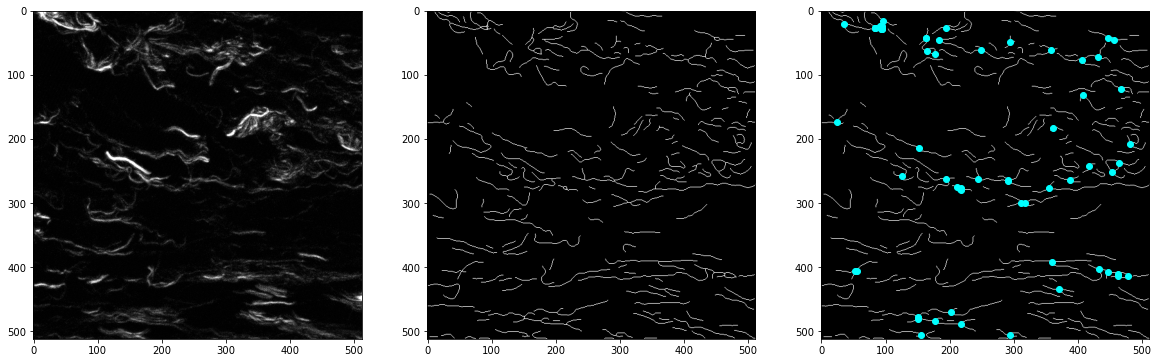

In [69]:
# create centerline from masks
centerline = CenterLine(centerline_image=io.imread("example_centerline.png"), associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

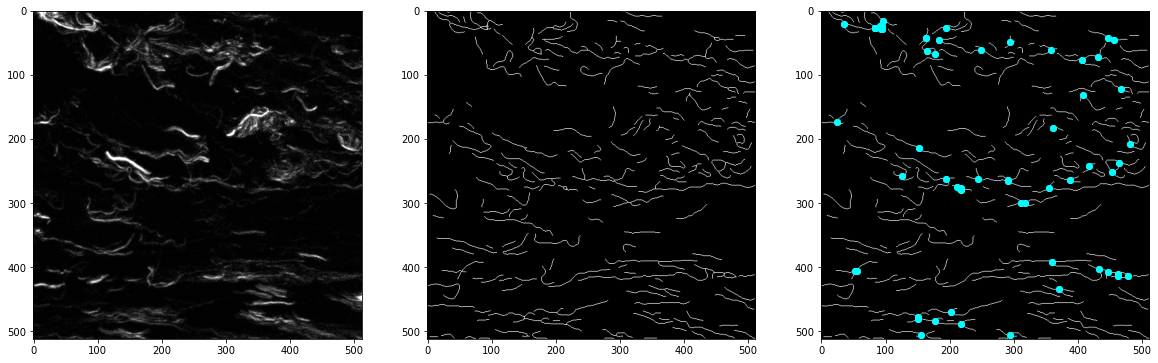

In [37]:
# create centerline from dataframe
centerline = CenterLine(dataframe=pd.read_csv("example_annotations.csv", index_col=0), associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

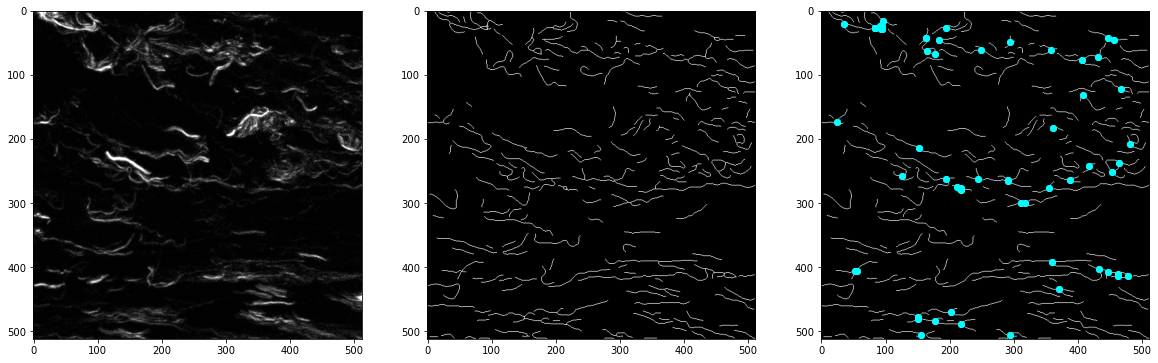

In [38]:
# create centerline from line_dict object
line_dict = centerline.line_dict
centerline = CenterLine(line_dict=line_dict, associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

In [39]:
### compute centerline features, example using centerline_image
centerline = CenterLine(centerline_image=io.imread("example_centerline.png"), associate_image=io.imread("example_image.tif")) # joints are NOT broken by default
centerline.compute_fiber_feats() 
print(centerline.feats)

{'cir_mean': 0.03231245854517084, 'cir_var': 0.4776088400869324, 'len_mean': 35.05, 'len_var': 28.705119119006696, 'waviness': 0.3594177829526412, 'intensity': 7789, 'density': array([[0.00000000e+00, 1.31350121e-05, 1.52563358e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.48839187e-05, 1.54940108e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.31350121e-05, 1.30400793e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.40149222e-02, 8.09045146e-02, 1.58691565e-01, ...,
        5.71384307e-01, 5.32496967e-01, 4.95396219e-01],
       [2.42596351e-02, 5.79699632e-02, 1.14203925e-01, ...,
        7.48074808e-01, 7.33518498e-01, 7.08760211e-01],
       [1.38045454e-02, 3.32272409e-02, 6.59031556e-02, ...,
        8.77616666e-01, 8.94105602e-01, 8.87972000e-01]])}


In [40]:
### compute centerline features, example using dataframe
centerline = CenterLine(dataframe=pd.read_csv("example_annotations.csv", index_col=0), associate_image=io.imread("example_image.tif"))
centerline.compute_fiber_feats() 
print(centerline.feats)

{'cir_mean': 0.03445705356282125, 'cir_var': 0.49306226835862066, 'len_mean': 34.88235294117647, 'len_var': 28.678191153859984, 'waviness': 0.35934463156188934, 'intensity': 7787, 'density': array([[0.00000000e+00, 1.31350121e-05, 1.52563358e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.48839187e-05, 1.54940108e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.31350121e-05, 1.30400793e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.40149222e-02, 8.09045146e-02, 1.58691565e-01, ...,
        5.71384307e-01, 5.32496967e-01, 4.95396219e-01],
       [2.42596351e-02, 5.79699632e-02, 1.14203925e-01, ...,
        7.48074808e-01, 7.33518498e-01, 7.08760211e-01],
       [1.38045454e-02, 3.32272409e-02, 6.59031556e-02, ...,
        8.77616666e-01, 8.94105602e-01, 8.87972000e-01]])}


In [187]:
### currently, breaking joints + linking fiber is lossy, safest way is to work with all masks

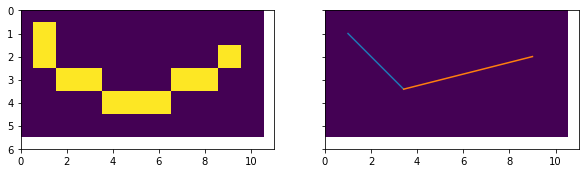

Length: 10.00, Waveiness: 0.4869 



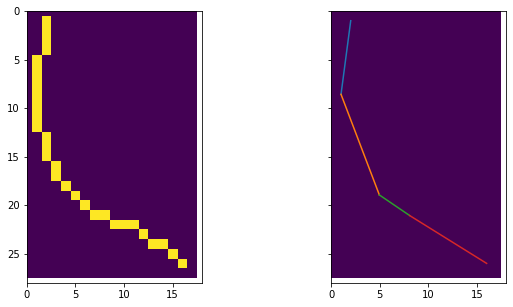

Length: 30.00, Waveiness: 0.2470 



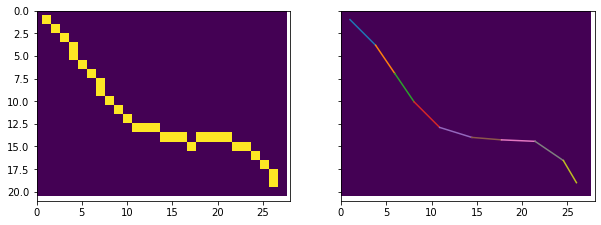

Length: 29.00, Waveiness: 0.2163 



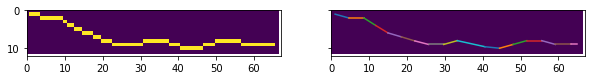

Length: 65.00, Waveiness: 0.1510 



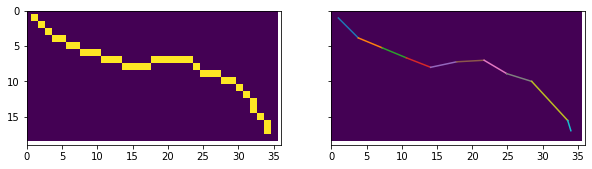

Length: 36.00, Waveiness: 0.2039 



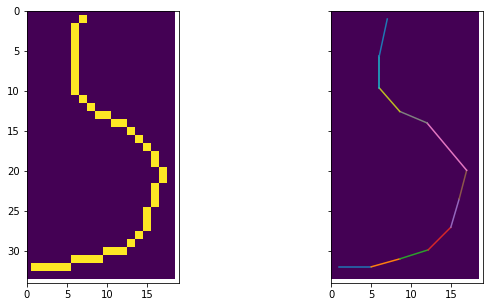

Length: 43.00, Waveiness: 0.2303 



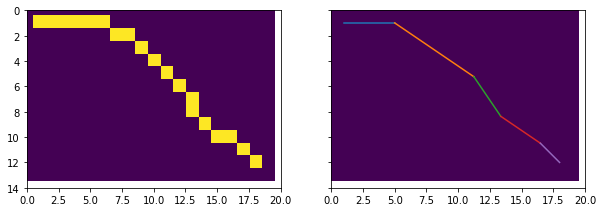

Length: 19.00, Waveiness: 0.1721 



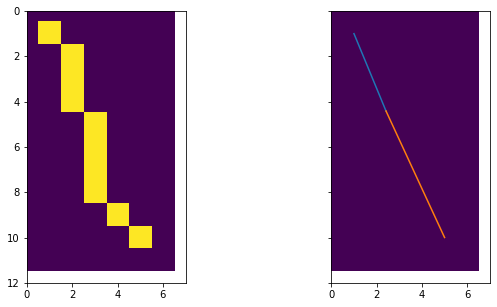

Length: 10.00, Waveiness: 0.1516 



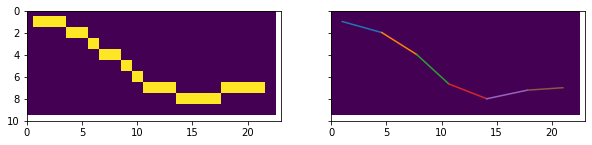

Length: 21.00, Waveiness: 0.1873 



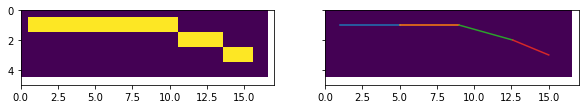

Length: 15.00, Waveiness: 0.1004 



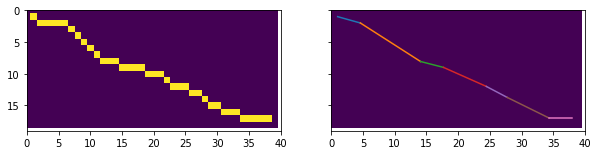

Length: 38.00, Waveiness: 0.1822 



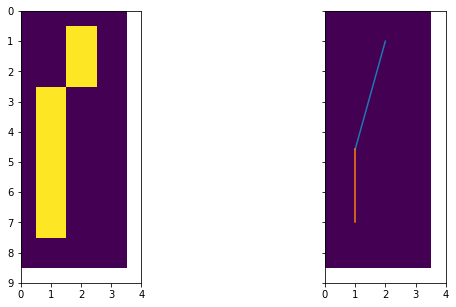

Length: 7.00, Waveiness: 0.1033 



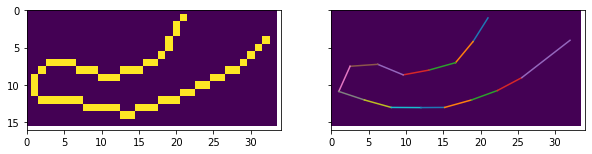

Length: 56.00, Waveiness: 0.3718 



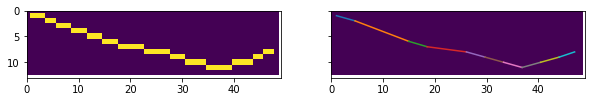

Length: 47.00, Waveiness: 0.1818 



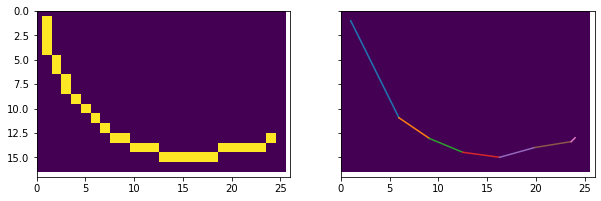

Length: 29.00, Waveiness: 0.1946 



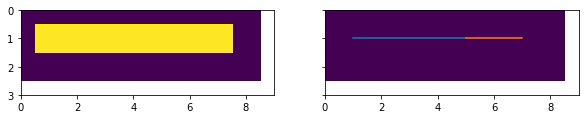

Length: 7.00, Waveiness: 0.0000 



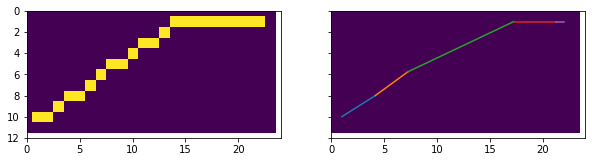

Length: 22.00, Waveiness: 0.1518 



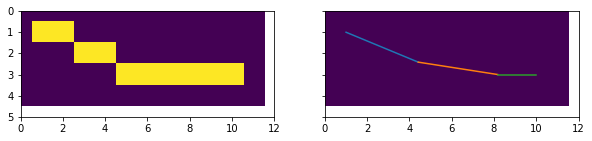

Length: 10.00, Waveiness: 0.1324 



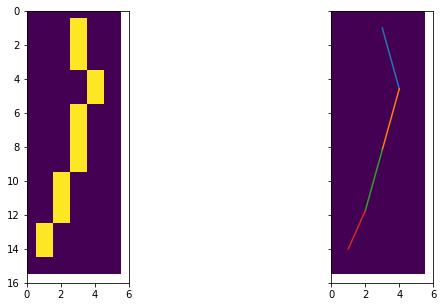

Length: 14.00, Waveiness: 0.2024 



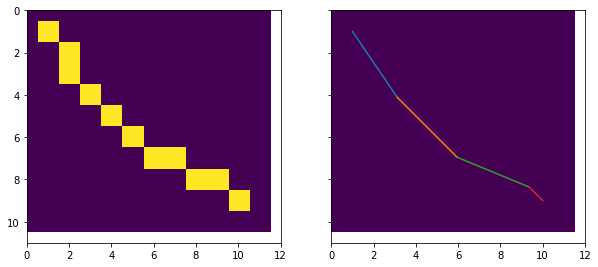

Length: 11.00, Waveiness: 0.1393 



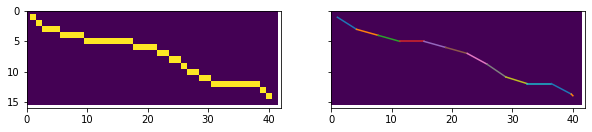

Length: 40.00, Waveiness: 0.1619 



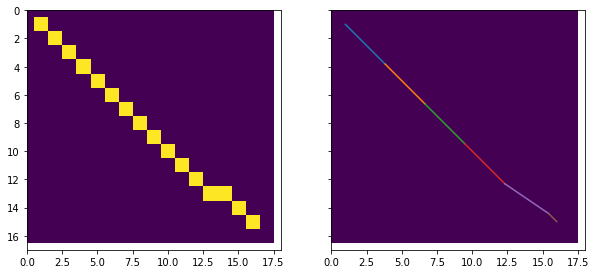

Length: 16.00, Waveiness: 0.0358 



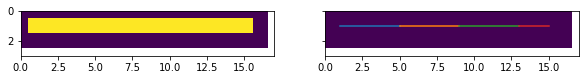

Length: 15.00, Waveiness: 0.0000 



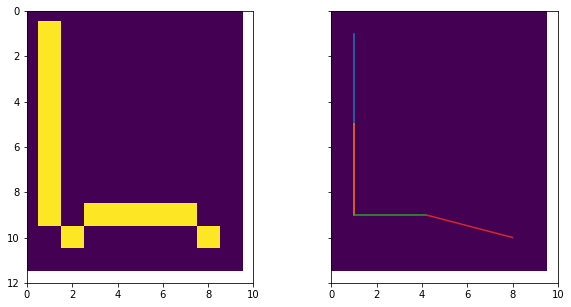

Length: 16.00, Waveiness: 0.5497 



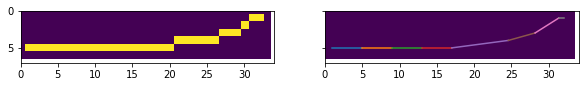

Length: 32.00, Waveiness: 0.0850 



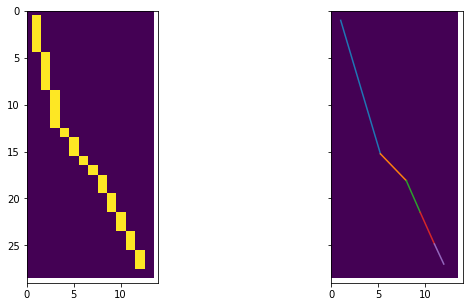

Length: 27.00, Waveiness: 0.1745 



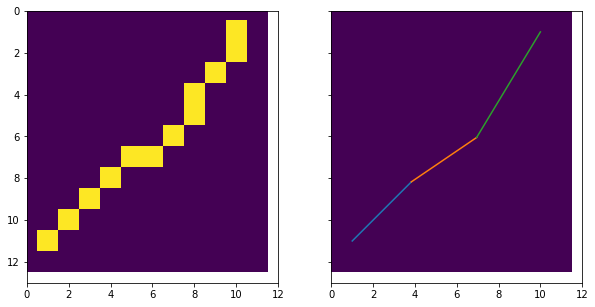

Length: 12.00, Waveiness: 0.1369 



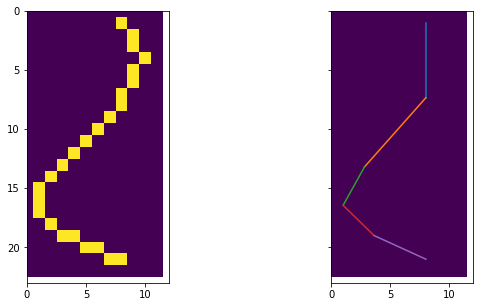

Length: 24.00, Waveiness: 0.4491 



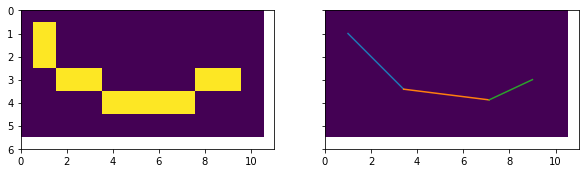

Length: 10.00, Waveiness: 0.3664 



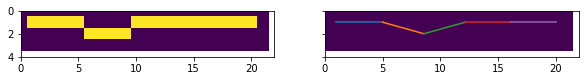

Length: 20.00, Waveiness: 0.1271 



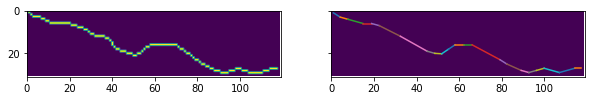

Length: 118.00, Waveiness: 0.2140 



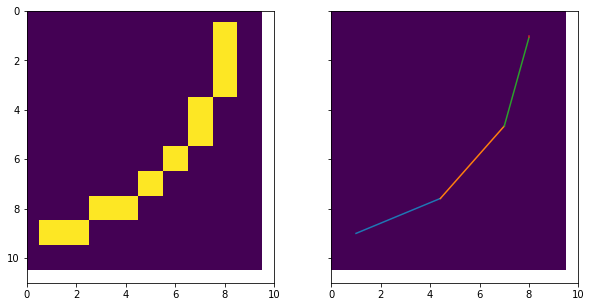

Length: 11.00, Waveiness: 0.1991 



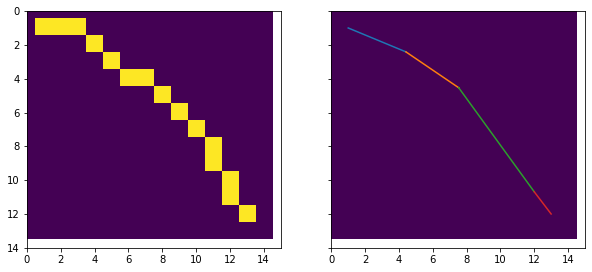

Length: 15.00, Waveiness: 0.1619 



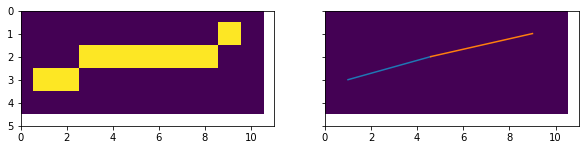

Length: 9.00, Waveiness: 0.1319 



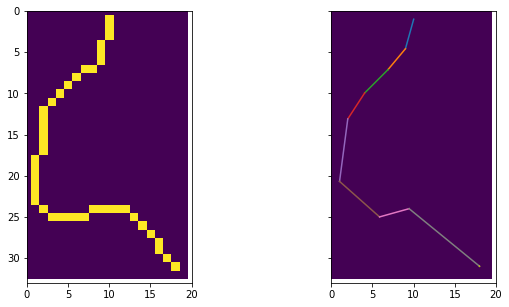

Length: 42.00, Waveiness: 0.3725 



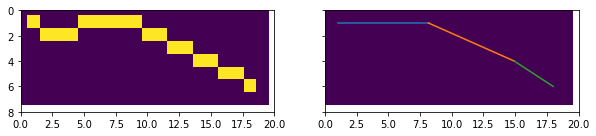

Length: 18.00, Waveiness: 0.2314 



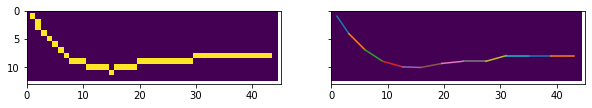

Length: 44.00, Waveiness: 0.1406 



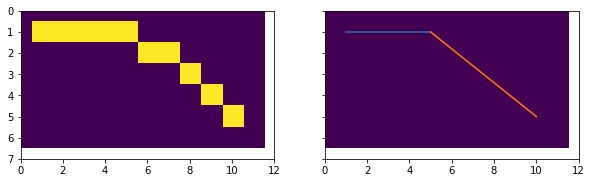

Length: 10.00, Waveiness: 0.1516 



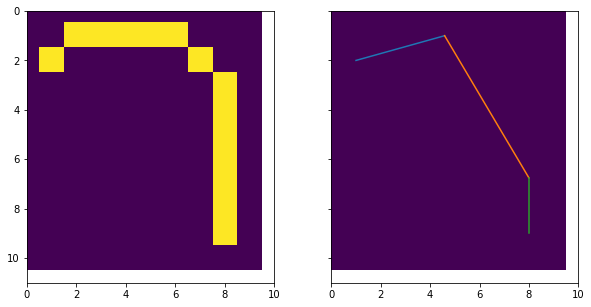

Length: 14.00, Waveiness: 0.6019 



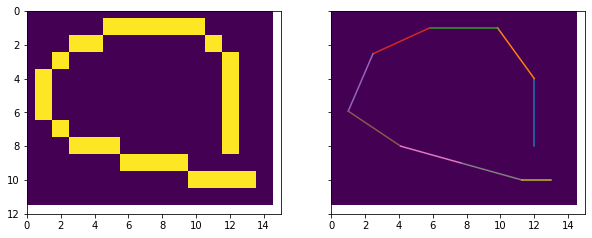

Length: 31.00, Waveiness: 0.4069 



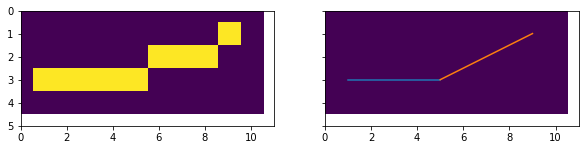

Length: 9.00, Waveiness: 0.1319 



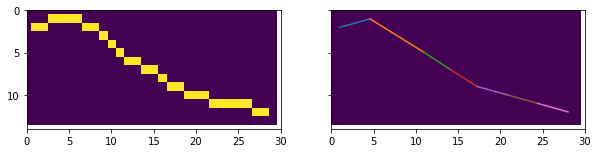

Length: 28.00, Waveiness: 0.1966 



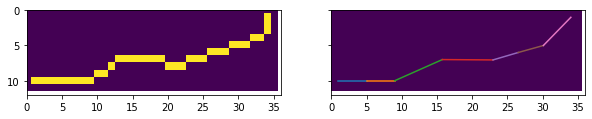

Length: 36.00, Waveiness: 0.2263 



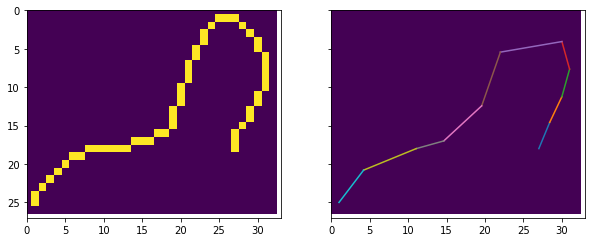

Length: 53.00, Waveiness: 0.5001 



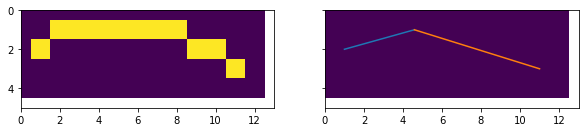

Length: 11.00, Waveiness: 0.2122 



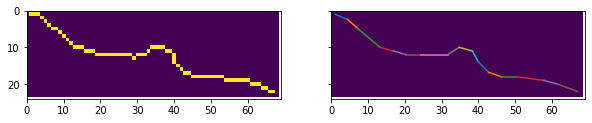

Length: 69.00, Waveiness: 0.2121 



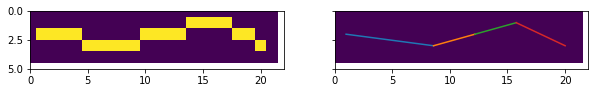

Length: 20.00, Waveiness: 0.2287 



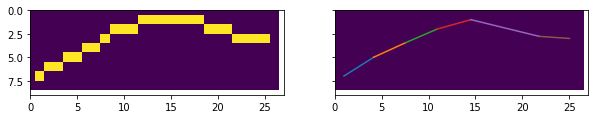

Length: 25.00, Waveiness: 0.1950 



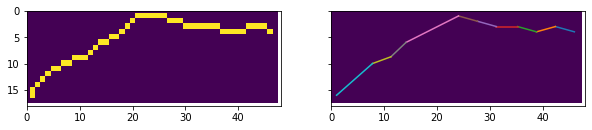

Length: 47.00, Waveiness: 0.2009 



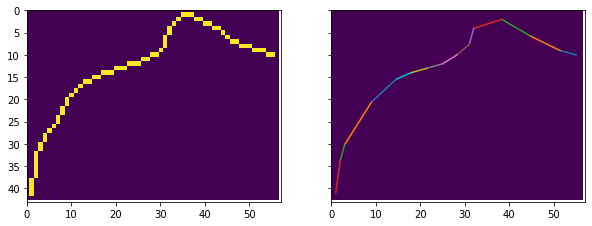

Length: 71.00, Waveiness: 0.2715 



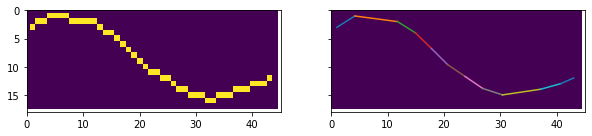

Length: 43.00, Waveiness: 0.1960 



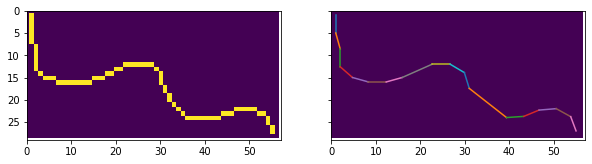

Length: 72.00, Waveiness: 0.2585 



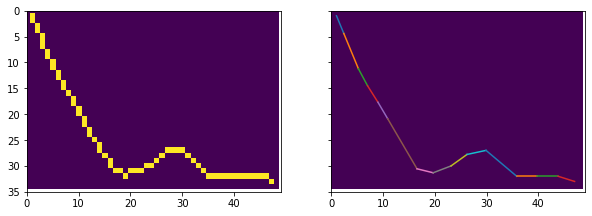

Length: 61.00, Waveiness: 0.2424 



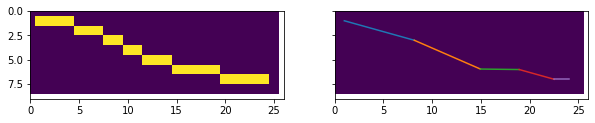

Length: 24.00, Waveiness: 0.1470 



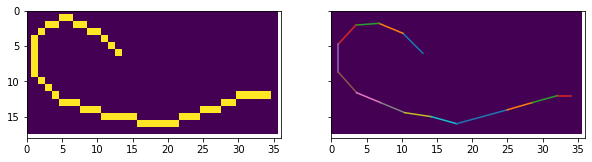

Length: 51.00, Waveiness: 0.2720 



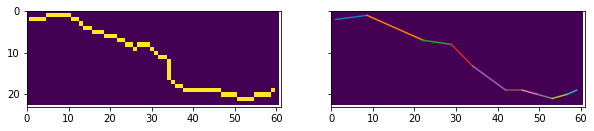

Length: 63.00, Waveiness: 0.2851 



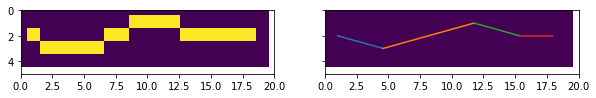

Length: 18.00, Waveiness: 0.2113 



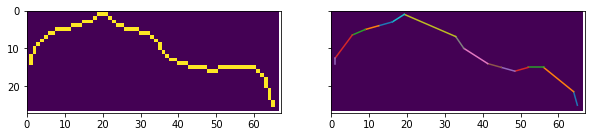

Length: 74.00, Waveiness: 0.2565 



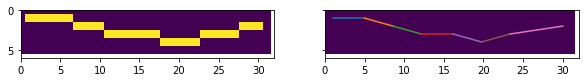

Length: 30.00, Waveiness: 0.1507 



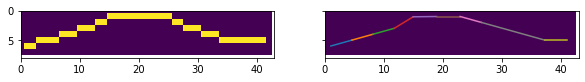

Length: 41.00, Waveiness: 0.1462 



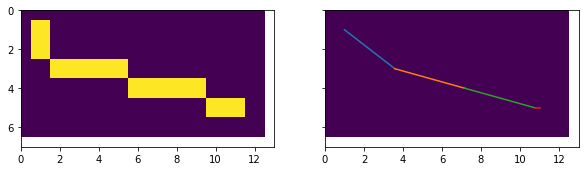

Length: 12.00, Waveiness: 0.2253 



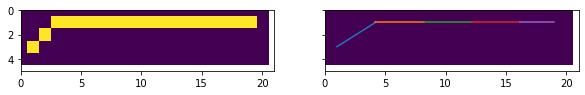

Length: 19.00, Waveiness: 0.0431 



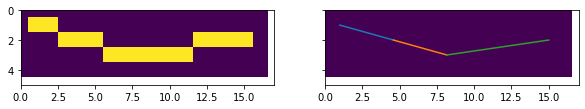

Length: 15.00, Waveiness: 0.1745 



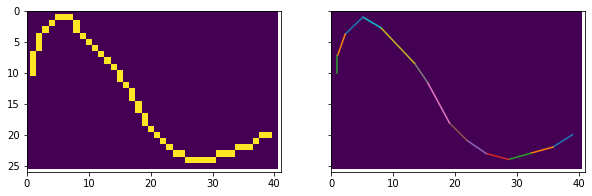

Length: 49.00, Waveiness: 0.2456 



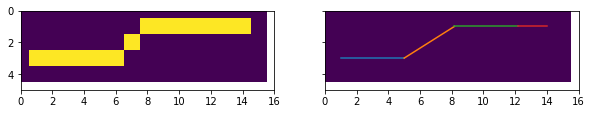

Length: 14.00, Waveiness: 0.1252 



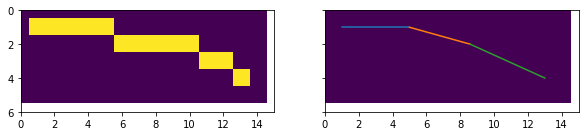

Length: 13.00, Waveiness: 0.1454 



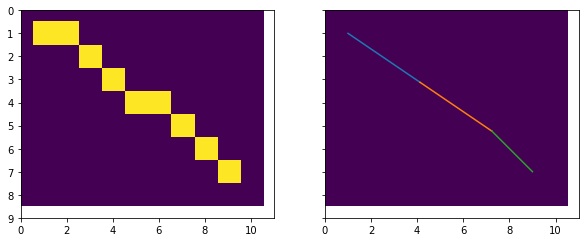

Length: 9.00, Waveiness: 0.1099 



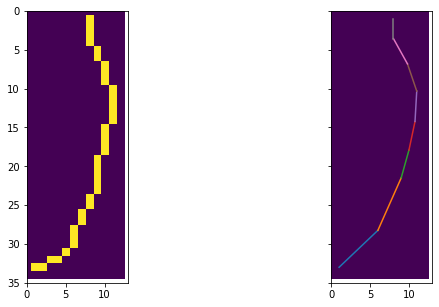

Length: 35.00, Waveiness: 0.1910 



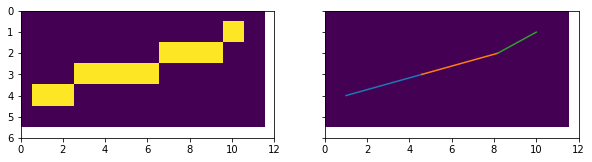

Length: 10.00, Waveiness: 0.1703 



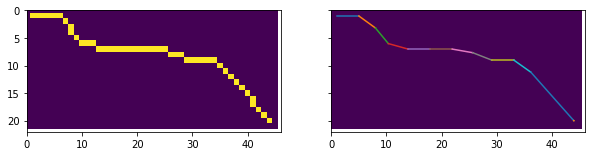

Length: 46.00, Waveiness: 0.1555 



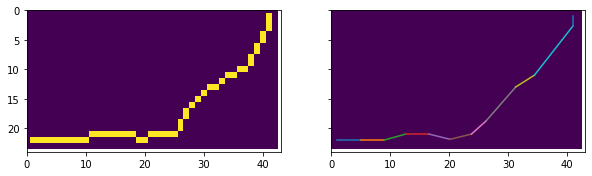

Length: 48.00, Waveiness: 0.2042 



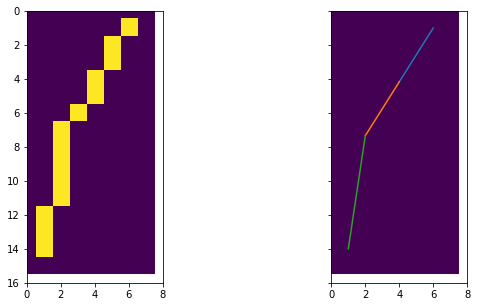

Length: 14.00, Waveiness: 0.1654 



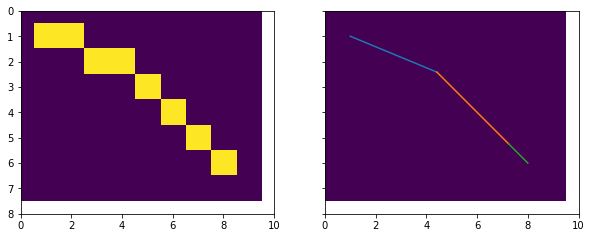

Length: 8.00, Waveiness: 0.0894 



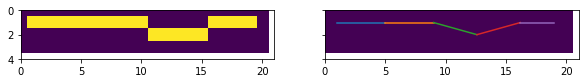

Length: 19.00, Waveiness: 0.1318 



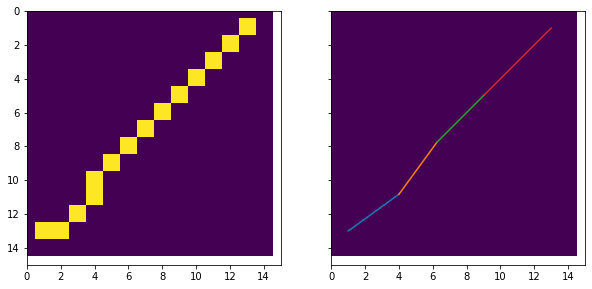

Length: 14.00, Waveiness: 0.0798 



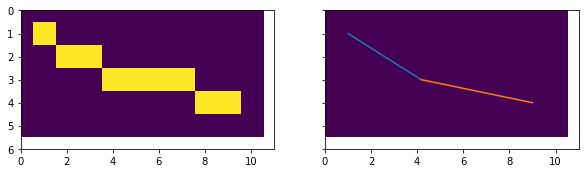

Length: 9.00, Waveiness: 0.1512 



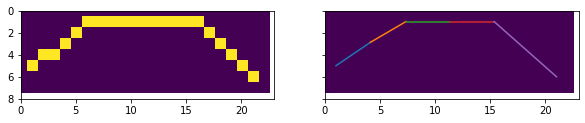

Length: 21.00, Waveiness: 0.1449 



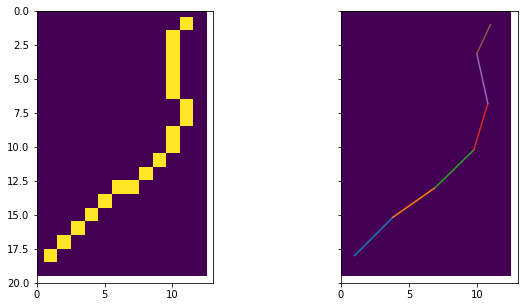

Length: 19.00, Waveiness: 0.2084 



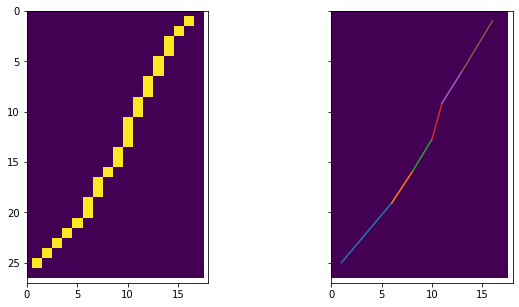

Length: 25.00, Waveiness: 0.1611 



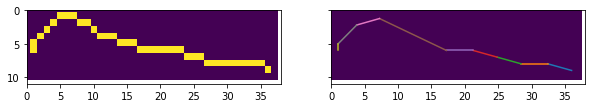

Length: 37.00, Waveiness: 0.2029 



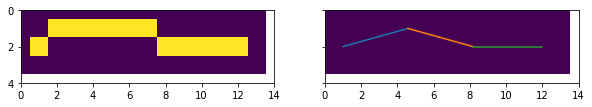

Length: 12.00, Waveiness: 0.1686 



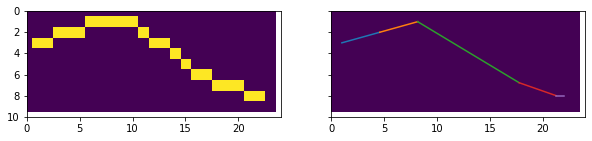

Length: 22.00, Waveiness: 0.2357 



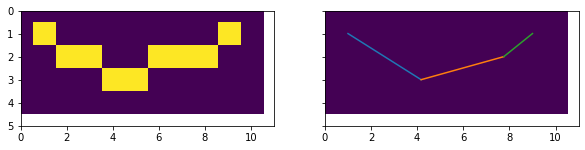

Length: 9.00, Waveiness: 0.3197 



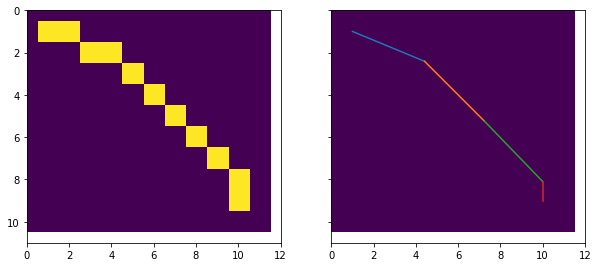

Length: 11.00, Waveiness: 0.0882 



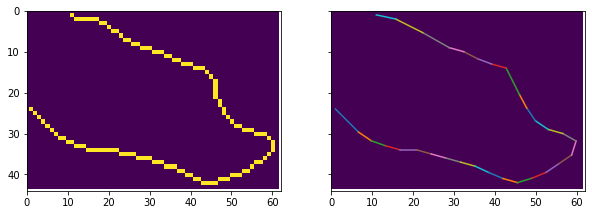

Length: 117.00, Waveiness: 0.2325 



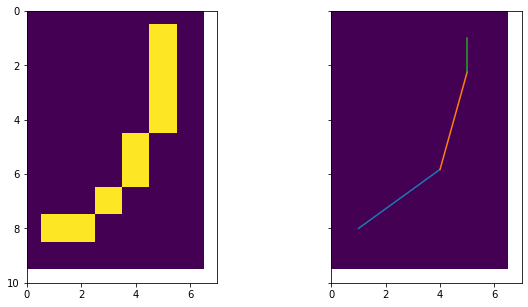

Length: 9.00, Waveiness: 0.2498 



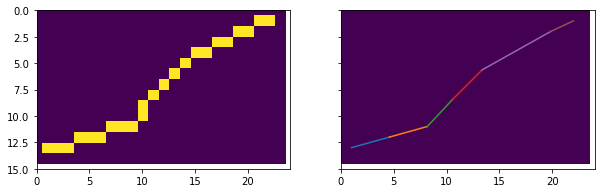

Length: 23.00, Waveiness: 0.2065 



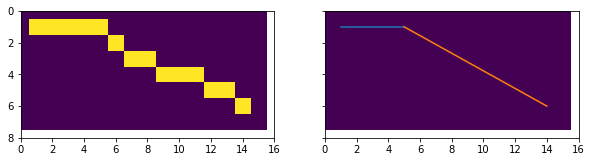

Length: 14.00, Waveiness: 0.1516 



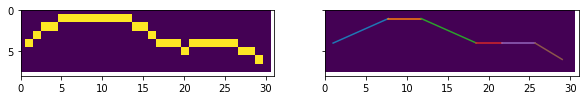

Length: 29.00, Waveiness: 0.2540 



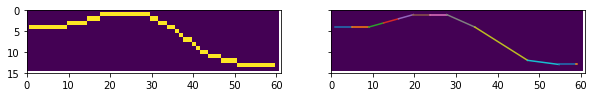

Length: 59.00, Waveiness: 0.1242 



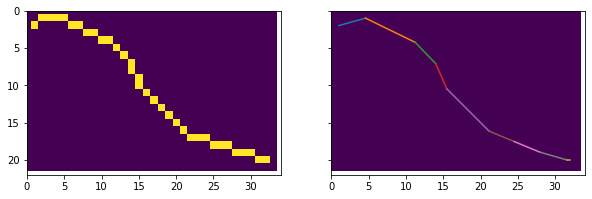

Length: 34.00, Waveiness: 0.1796 



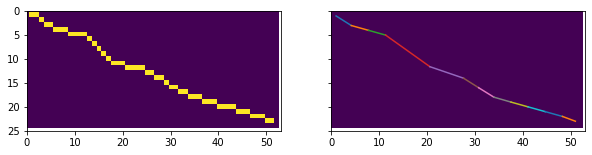

Length: 51.00, Waveiness: 0.1779 



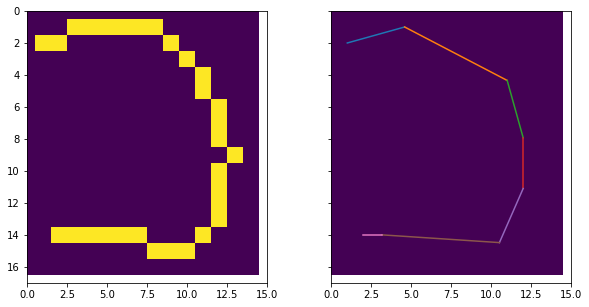

Length: 30.00, Waveiness: 0.4698 



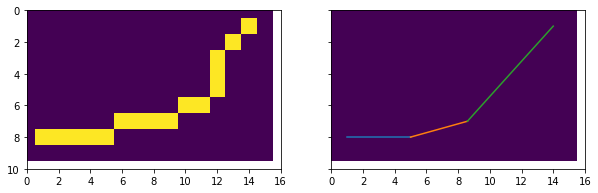

Length: 16.00, Waveiness: 0.2493 



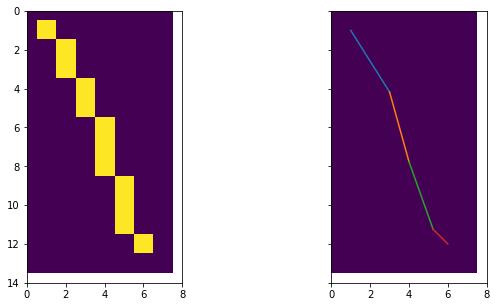

Length: 12.00, Waveiness: 0.1806 



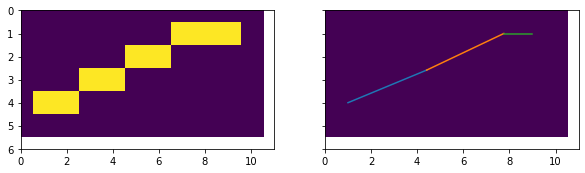

Length: 9.00, Waveiness: 0.1758 



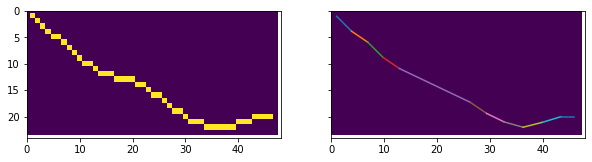

Length: 46.00, Waveiness: 0.1622 



Length: 30.00, Waveiness: 0.2787 



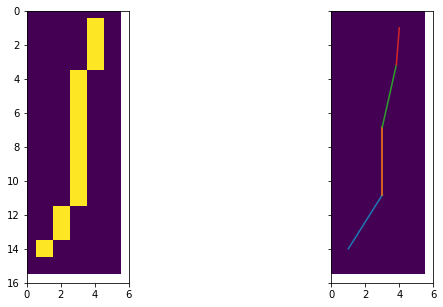

Length: 14.00, Waveiness: 0.1255 



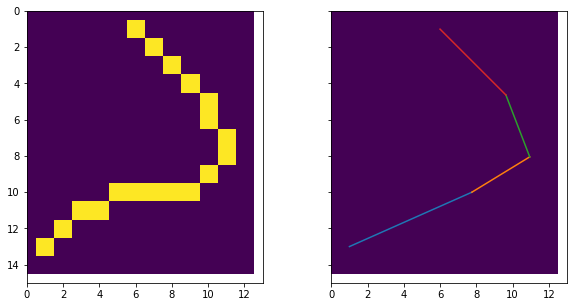

Length: 18.00, Waveiness: 0.4990 



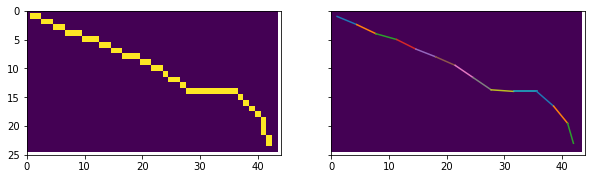

Length: 45.00, Waveiness: 0.1731 



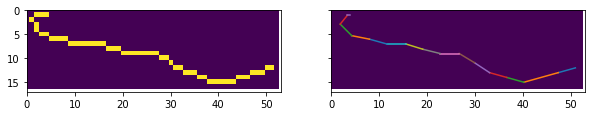

Length: 55.00, Waveiness: 0.3212 



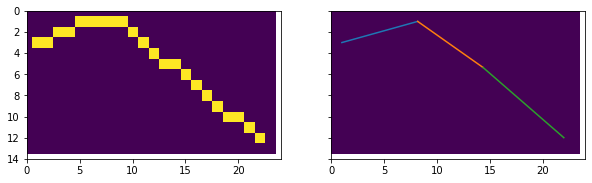

Length: 22.00, Waveiness: 0.2612 



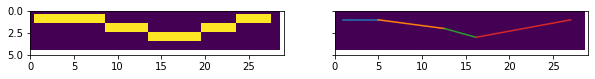

Length: 27.00, Waveiness: 0.1331 



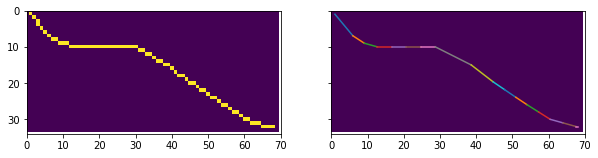

Length: 69.00, Waveiness: 0.1326 



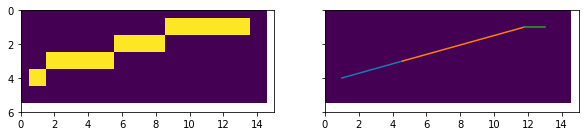

Length: 13.00, Waveiness: 0.1550 



Length: 34.00, Waveiness: 0.1518 



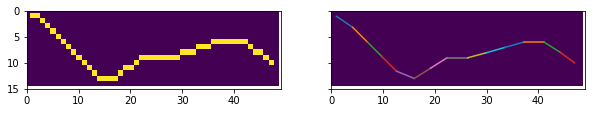

Length: 47.00, Waveiness: 0.1693 



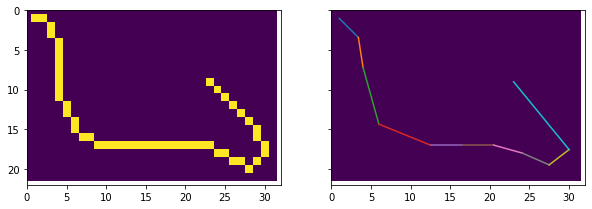

Length: 49.00, Waveiness: 0.3818 



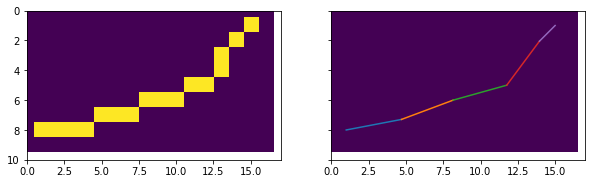

Length: 16.00, Waveiness: 0.2190 



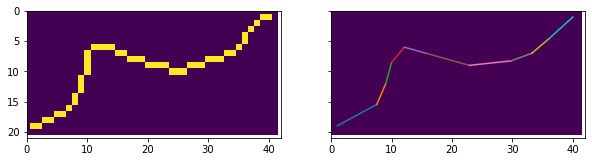

Length: 47.00, Waveiness: 0.3433 



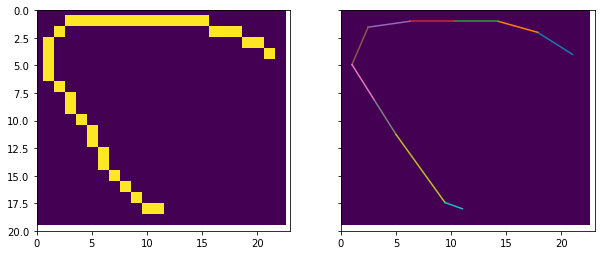

Length: 37.00, Waveiness: 0.2459 



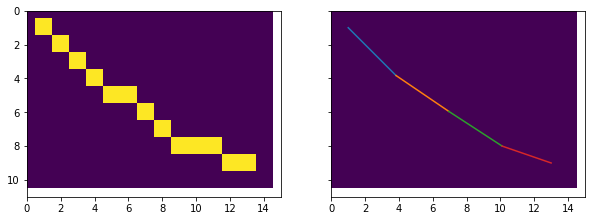

Length: 13.00, Waveiness: 0.1334 



Length: 36.00, Waveiness: 0.3120 



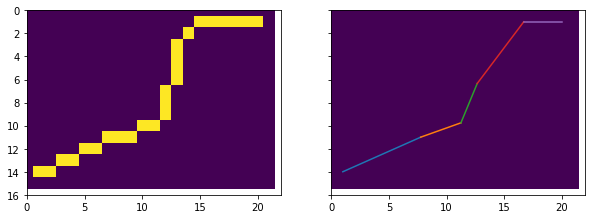

Length: 25.00, Waveiness: 0.3691 



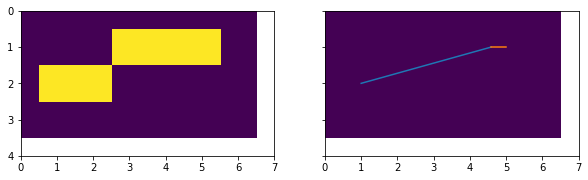

Length: 5.00, Waveiness: 0.1319 



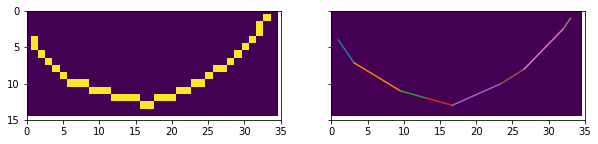

Length: 35.00, Waveiness: 0.2030 



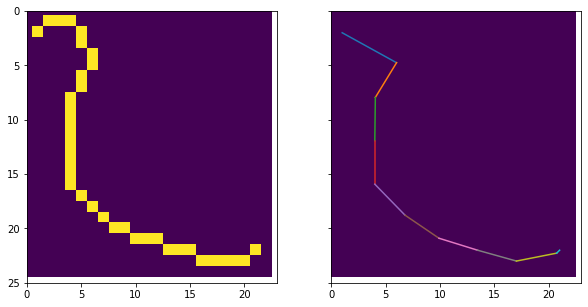

Length: 36.00, Waveiness: 0.2697 



Length: 36.00, Waveiness: 0.3056 



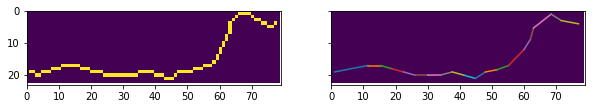

Length: 84.00, Waveiness: 0.2602 



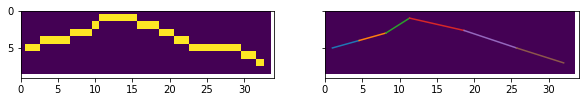

Length: 32.00, Waveiness: 0.2191 



Length: 35.00, Waveiness: 0.4306 



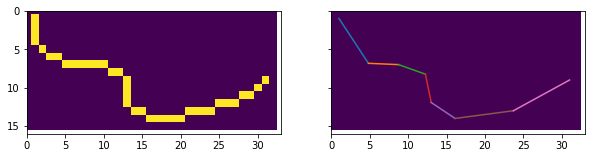

Length: 37.00, Waveiness: 0.3721 



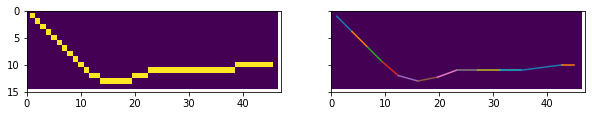

Length: 45.00, Waveiness: 0.0954 



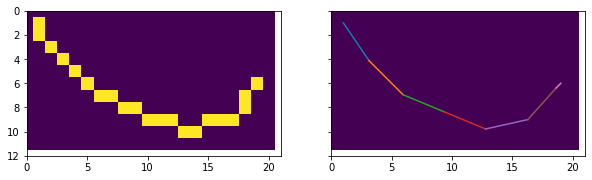

Length: 21.00, Waveiness: 0.2729 



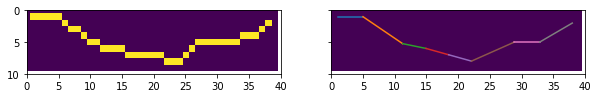

Length: 38.00, Waveiness: 0.2033 



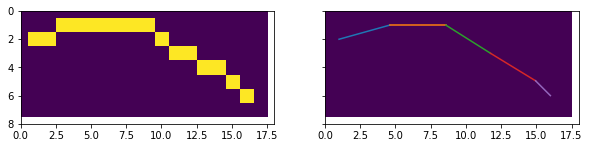

Length: 16.00, Waveiness: 0.1652 



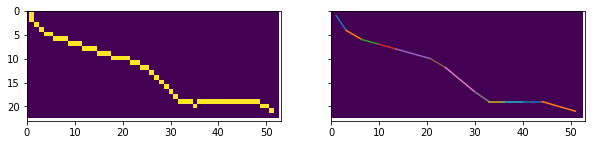

Length: 52.00, Waveiness: 0.1893 



Length: 35.00, Waveiness: 0.6022 



Length: 16.00, Waveiness: 0.0603 



Length: 35.00, Waveiness: 0.1085 



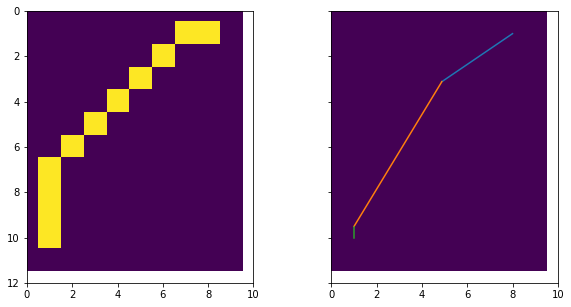

Length: 11.00, Waveiness: 0.1873 



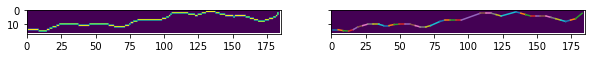

Length: 184.00, Waveiness: 0.1487 



Length: 16.00, Waveiness: 0.3233 



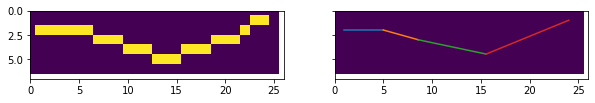

Length: 24.00, Waveiness: 0.2353 



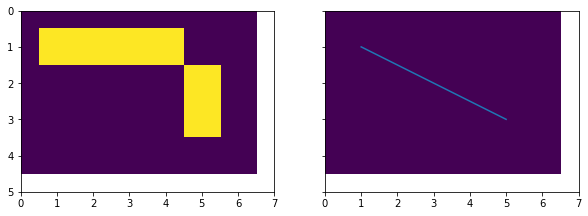

Length: 6.00, Waveiness: 0.0000 



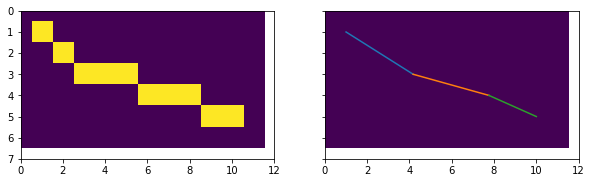

Length: 10.00, Waveiness: 0.1759 



Length: 70.00, Waveiness: 0.1753 



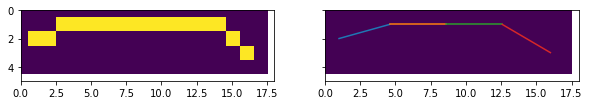

Length: 16.00, Waveiness: 0.0954 



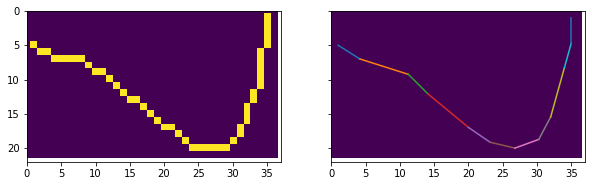

Length: 48.00, Waveiness: 0.2086 



Length: 47.00, Waveiness: 0.2498 



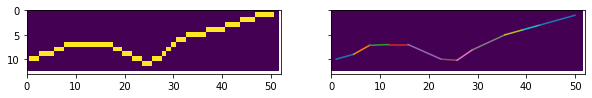

Length: 50.00, Waveiness: 0.2083 



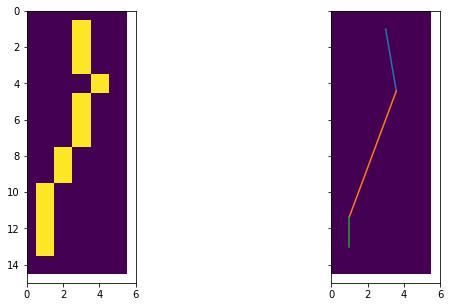

Length: 13.00, Waveiness: 0.2382 



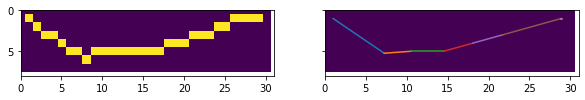

Length: 29.00, Waveiness: 0.1969 



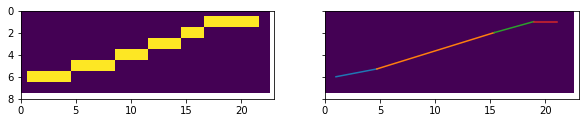

Length: 21.00, Waveiness: 0.1600 



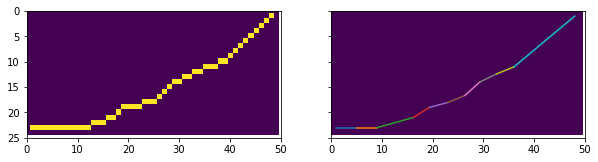

Length: 48.00, Waveiness: 0.1544 



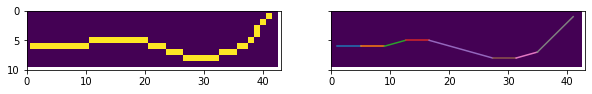

Length: 42.00, Waveiness: 0.1382 



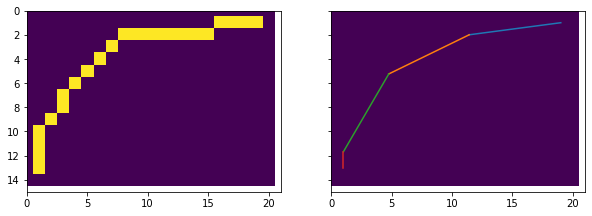

Length: 23.00, Waveiness: 0.2545 



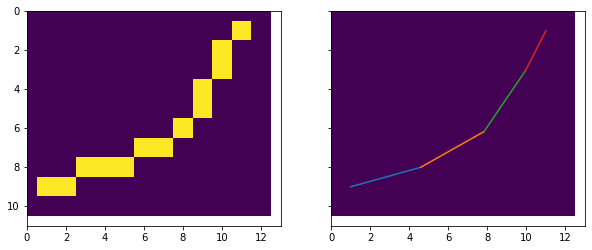

Length: 13.00, Waveiness: 0.2107 



Length: 17.00, Waveiness: 0.1586 



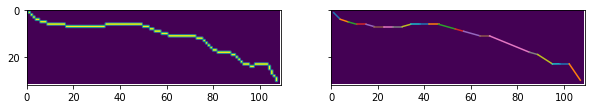

Length: 110.00, Waveiness: 0.1507 



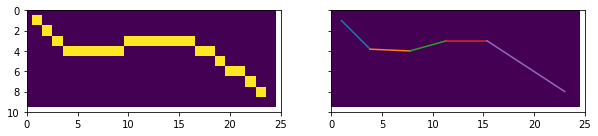

Length: 23.00, Waveiness: 0.1878 



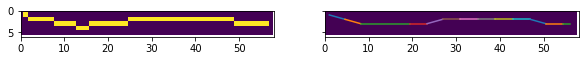

Length: 56.00, Waveiness: 0.0793 



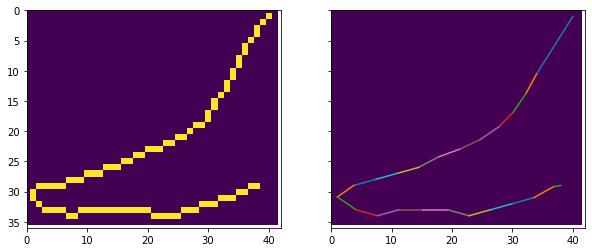

Length: 85.00, Waveiness: 0.2689 



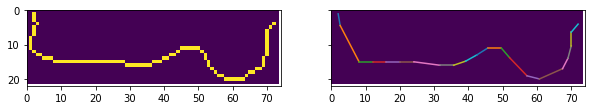

Length: 93.00, Waveiness: 0.2546 



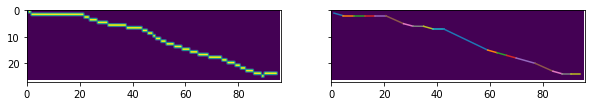

Length: 94.00, Waveiness: 0.1526 



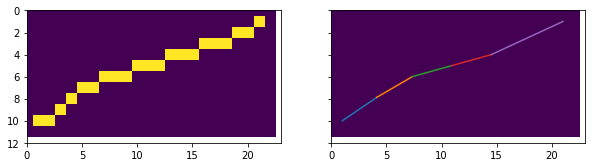

Length: 21.00, Waveiness: 0.1774 



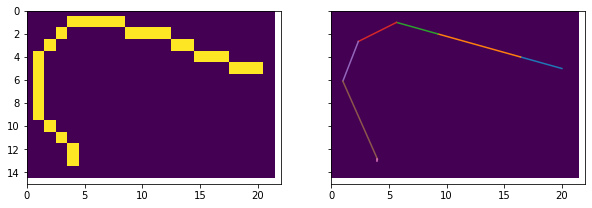

Length: 29.00, Waveiness: 0.3337 



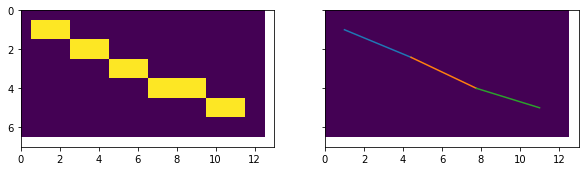

Length: 11.00, Waveiness: 0.1772 



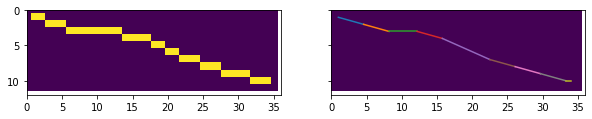

Length: 34.00, Waveiness: 0.1608 



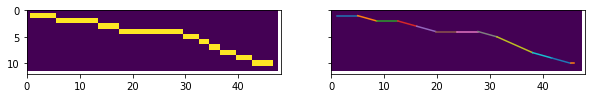

Length: 46.00, Waveiness: 0.1318 



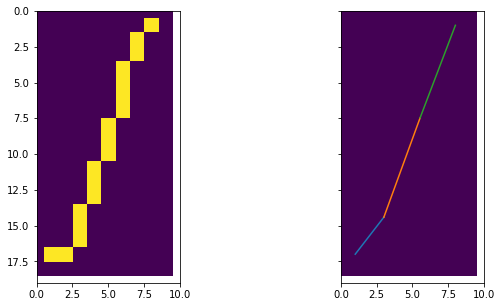

Length: 18.00, Waveiness: 0.2341 



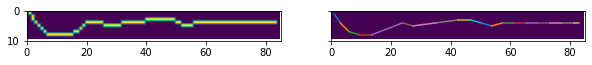

Length: 84.00, Waveiness: 0.1127 



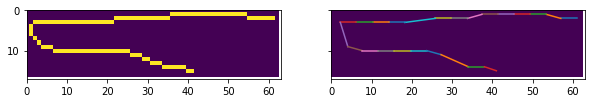

Length: 103.00, Waveiness: 0.1740 



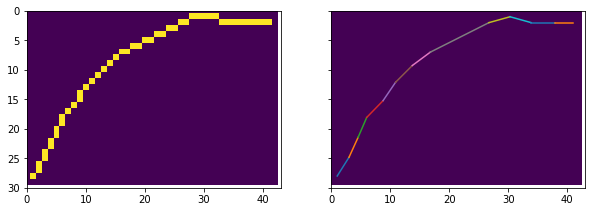

Length: 47.00, Waveiness: 0.1433 



Length: 13.00, Waveiness: 0.1476 



Length: 41.00, Waveiness: 0.2779 



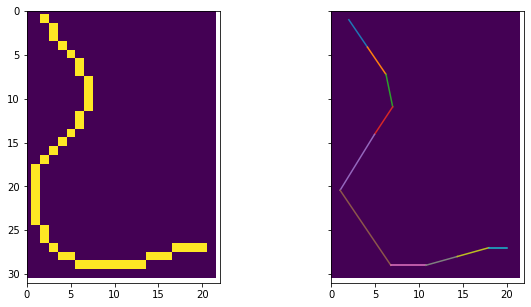

Length: 44.00, Waveiness: 0.3351 



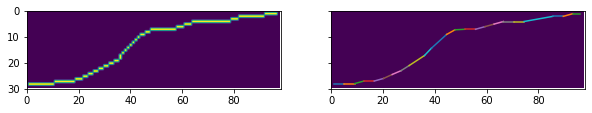

Length: 97.00, Waveiness: 0.1294 



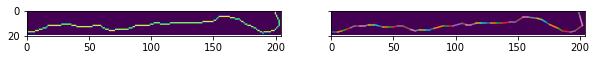

Length: 213.00, Waveiness: 0.1557 



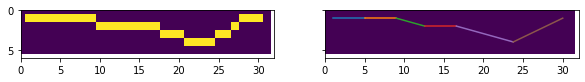

Length: 30.00, Waveiness: 0.1358 



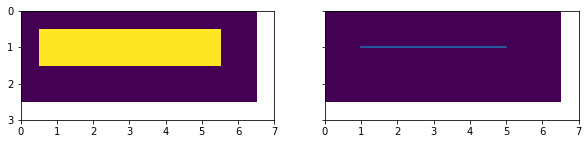

Length: 5.00, Waveiness: 0.0000 



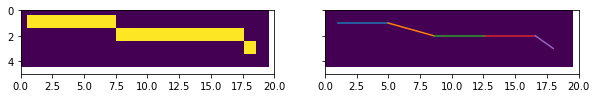

Length: 18.00, Waveiness: 0.0830 



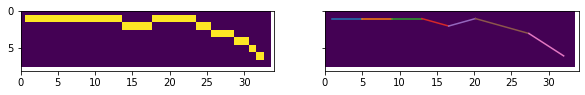

Length: 32.00, Waveiness: 0.1419 



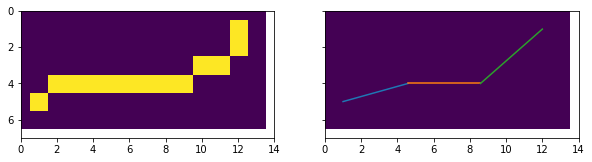

Length: 13.00, Waveiness: 0.2349 



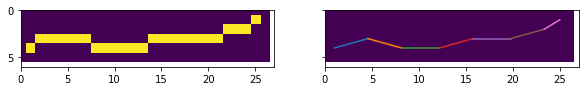

Length: 25.00, Waveiness: 0.1418 



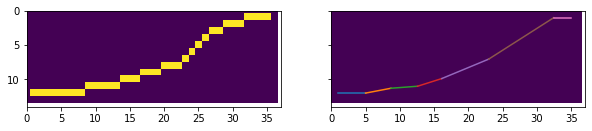

Length: 35.00, Waveiness: 0.1480 



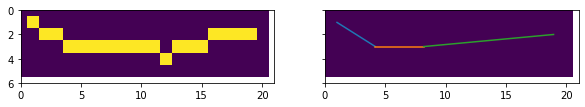

Length: 19.00, Waveiness: 0.2040 



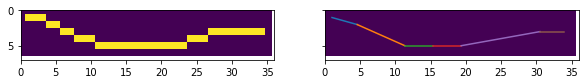

Length: 34.00, Waveiness: 0.1190 



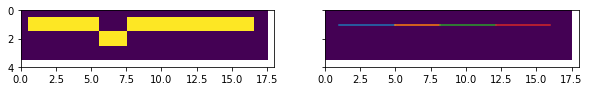

Length: 16.00, Waveiness: 0.1663 



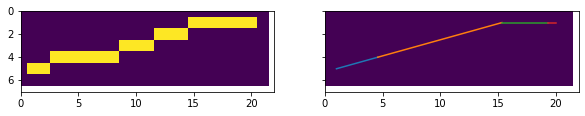

Length: 20.00, Waveiness: 0.1224 



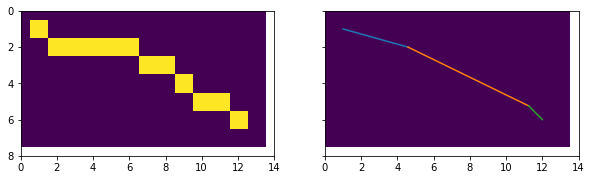

Length: 12.00, Waveiness: 0.1739 



Length: 87.00, Waveiness: 0.3426 



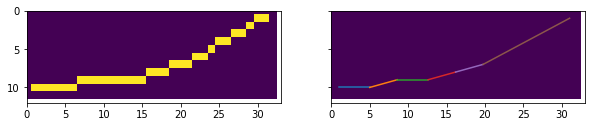

Length: 31.00, Waveiness: 0.1329 



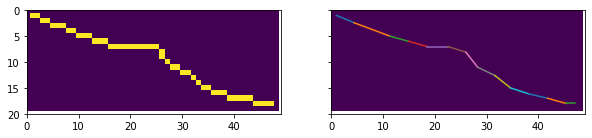

Length: 48.00, Waveiness: 0.1867 



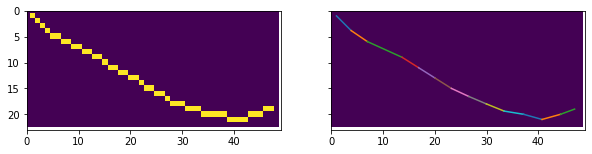

Length: 47.00, Waveiness: 0.1800 



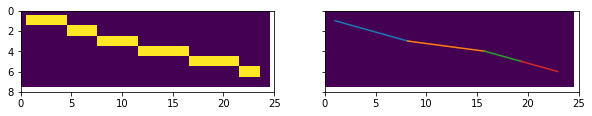

Length: 23.00, Waveiness: 0.1528 



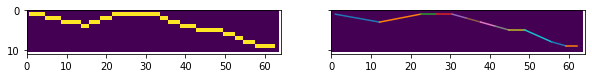

Length: 62.00, Waveiness: 0.1591 



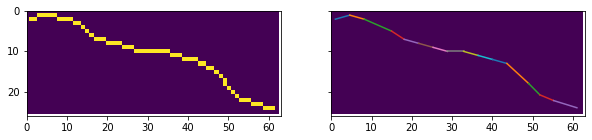

Length: 62.00, Waveiness: 0.1811 



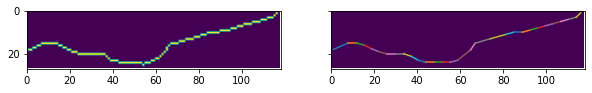

Length: 117.00, Waveiness: 0.1703 



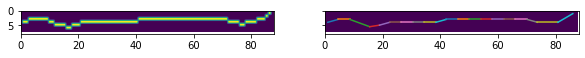

Length: 86.00, Waveiness: 0.0997 



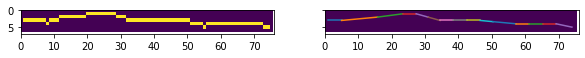

Length: 74.00, Waveiness: 0.1080 



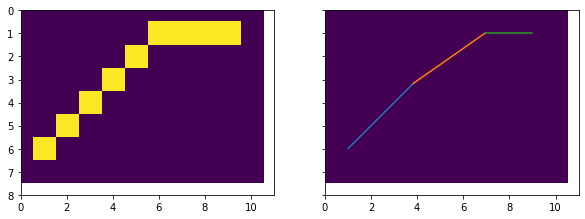

Length: 9.00, Waveiness: 0.1343 



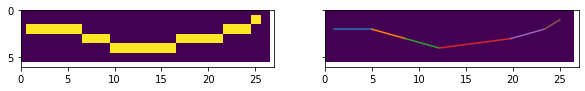

Length: 25.00, Waveiness: 0.1590 



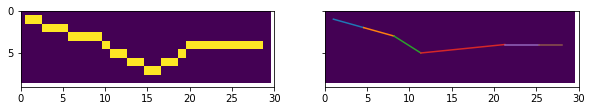

Length: 28.00, Waveiness: 0.2630 



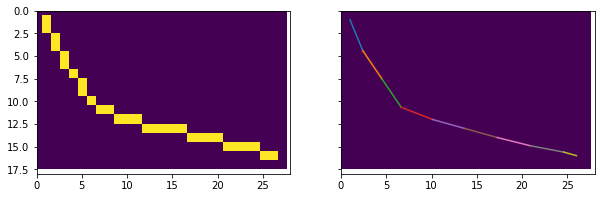

Length: 30.00, Waveiness: 0.1854 



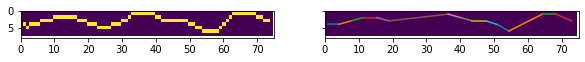

Length: 73.00, Waveiness: 0.2269 



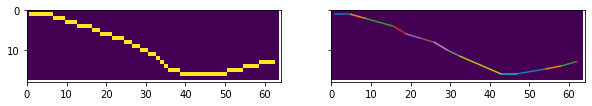

Length: 62.00, Waveiness: 0.1688 



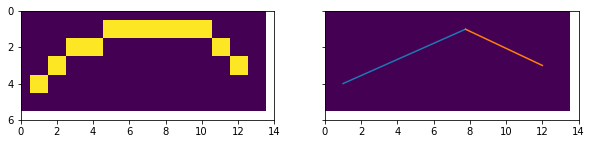

Length: 12.00, Waveiness: 0.3100 



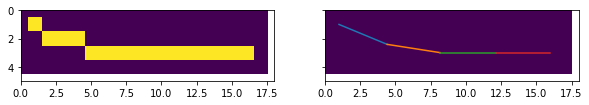

Length: 16.00, Waveiness: 0.0829 



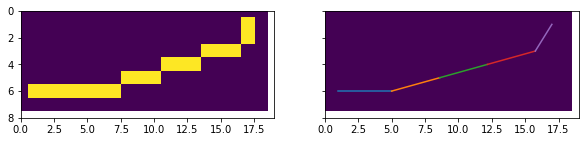

Length: 18.00, Waveiness: 0.2007 



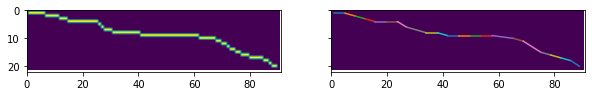

Length: 89.00, Waveiness: 0.1231 



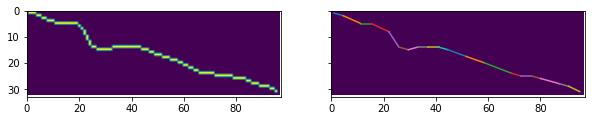

Length: 98.00, Waveiness: 0.1938 



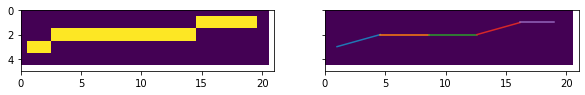

Length: 19.00, Waveiness: 0.0800 



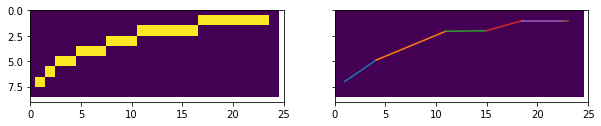

Length: 23.00, Waveiness: 0.1237 



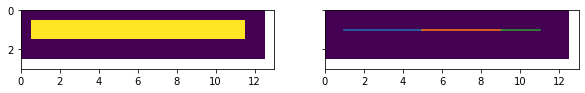

Length: 11.00, Waveiness: 0.0000 



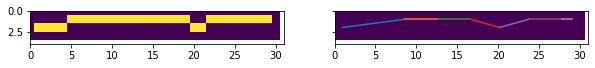

Length: 29.00, Waveiness: 0.1035 



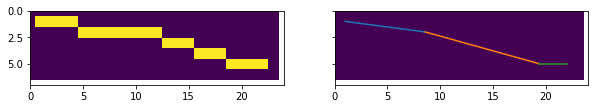

Length: 22.00, Waveiness: 0.1388 



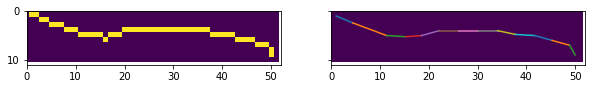

Length: 51.00, Waveiness: 0.1564 



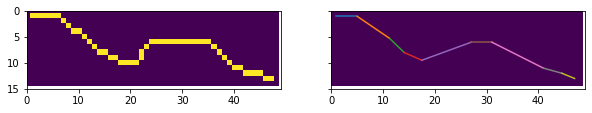

Length: 48.00, Waveiness: 0.2536 



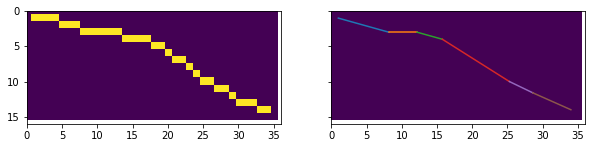

Length: 34.00, Waveiness: 0.1619 



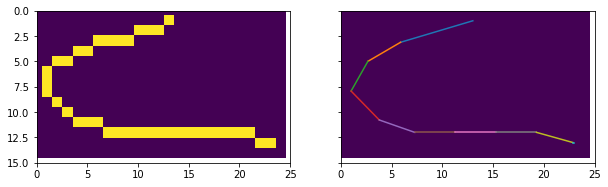

Length: 37.00, Waveiness: 0.2538 



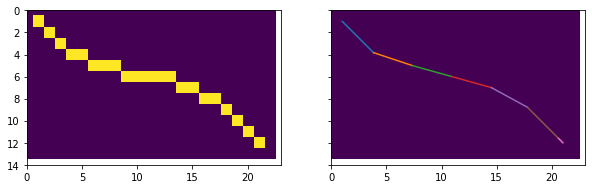

Length: 21.00, Waveiness: 0.1493 



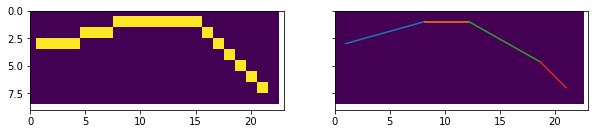

Length: 21.00, Waveiness: 0.1872 



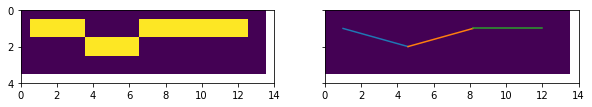

Length: 12.00, Waveiness: 0.1686 



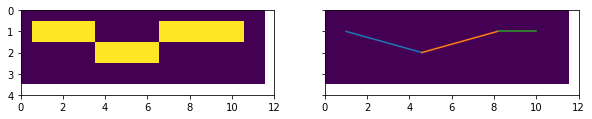

Length: 10.00, Waveiness: 0.1902 



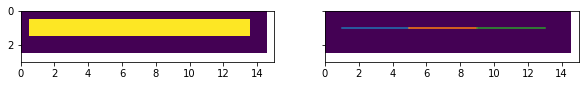

Length: 13.00, Waveiness: 0.0000 



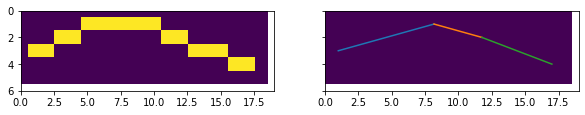

Length: 17.00, Waveiness: 0.2288 



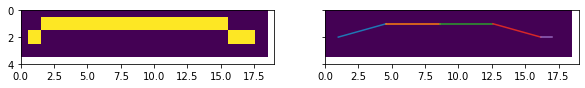

Length: 17.00, Waveiness: 0.0865 



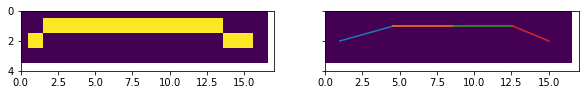

Length: 15.00, Waveiness: 0.0760 



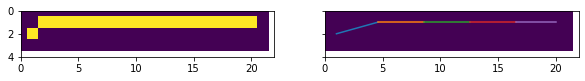

Length: 20.00, Waveiness: 0.0257 



In [130]:
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad( region.image, (1, 1) )
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length/seg_length))
    split_points = [int(i*seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
    if len(splitter) < 1: fragments = [shape_line]
    else: fragments = split(shape_line, splitter)
    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image* 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))
    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waviness: {waviness:.4f} \n')
    

### Read centerlines from a .mat file produced by ctFIRE

At least one of centerline_image, line_dict, and dataframe should be provided.


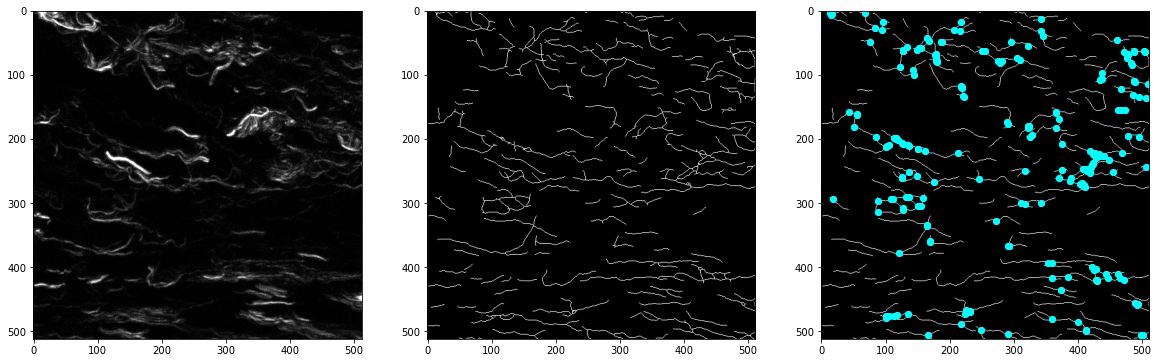

In [51]:
mat = sio.loadmat('ctFIREout_example_image.mat')
mat_data = mat['data']
centerline_mat = CenterLine()
line_dict = centerline_mat.mat_to_lines(mat_data)
centerline_mat = CenterLine(line_dict=line_dict, associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_mat.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_mat.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_mat.joint_filter(centerline_mat.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_mat.export_line_dict('example_image_ctFIRE_line_dict.csv')

In [52]:
### compute features from ctFIRE extracted centerline, note that the range of cir_mean is Pi (3.14, 5% error is ~0.15)
centerline_mat.compute_fiber_feats() 
print(centerline_mat.feats)

{'cir_mean': 0.14778381676390673, 'cir_var': 0.42927822463511817, 'len_mean': 31.547892720306514, 'len_var': 28.10589249387715, 'waviness': 0.36656376526686274, 'intensity': 8590, 'density': array([[0.48706934, 0.63781618, 0.77081227, ..., 0.        , 0.        ,
        0.        ],
       [0.45103094, 0.57156955, 0.67792491, ..., 0.        , 0.        ,
        0.        ],
       [0.36240949, 0.45103094, 0.5292357 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.23703384, 0.14453148,
        0.07486926],
       [0.        , 0.        , 0.        , ..., 0.34202339, 0.21855887,
        0.11711709],
       [0.        , 0.        , 0.        , ..., 0.44059027, 0.29112007,
        0.1599341 ]])}


### Run ridge detector on a image

At least one of centerline_image, line_dict, and dataframe should be provided.


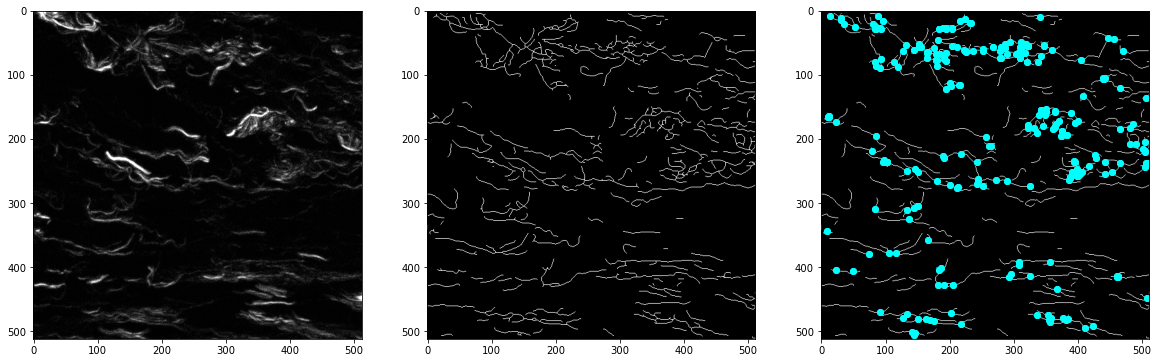

In [41]:
centerline_ridge = CenterLine(associate_image=io.imread("example_image.tif"))
line_dict = centerline_ridge.ridge_detector(config_fname="ridge_detector_params.json")
centerline_ridge = CenterLine(line_dict=line_dict, associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_ridge.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_ridge.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_ridge.joint_filter(centerline_ridge.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_ridge.export_line_dict('example_image_ridge_line_dict.csv')

In [45]:
centerline_ridge.compute_fiber_feats() 
print(centerline_ridge.feats)

{'cir_mean': -0.028427958319745317, 'cir_var': 0.5385896961214017, 'len_mean': 28.174216027874564, 'len_var': 23.655872649228932, 'waviness': 0.39114587603625167, 'intensity': 8281, 'density': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.01977582e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.86983086e-01, 6.83280484e-01, 6.77476084e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.46032390e-01, 8.64894574e-01, 8.69598566e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.44146007e-01, 9.84912059e-01, 1.00000000e+00]])}


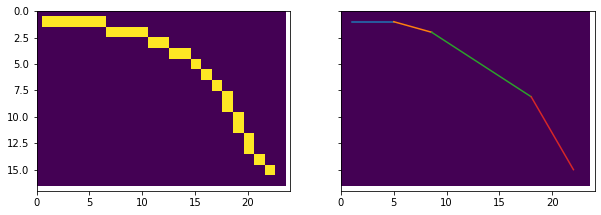

Length: 25.00, Waveiness: 0.3676 



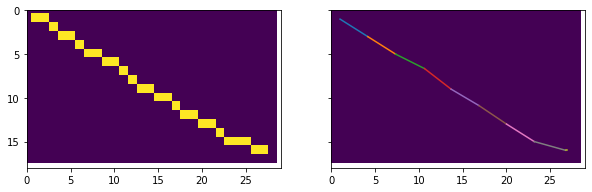

Length: 27.00, Waveiness: 0.3122 



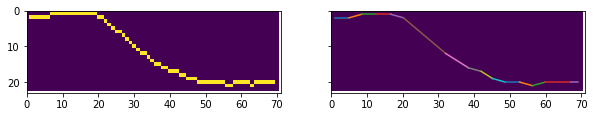

Length: 69.00, Waveiness: 0.2918 



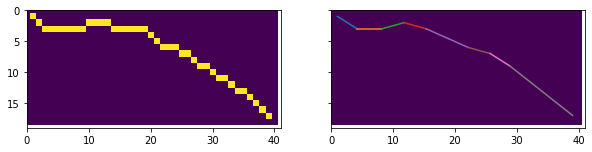

Length: 39.00, Waveiness: 0.3598 



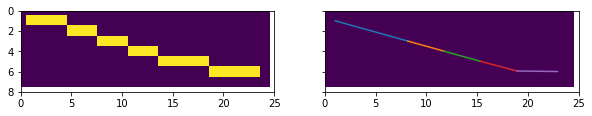

Length: 23.00, Waveiness: 0.2644 



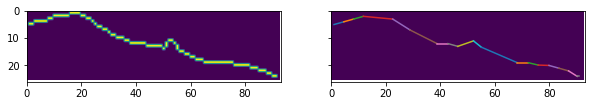

Length: 93.00, Waveiness: 0.4498 



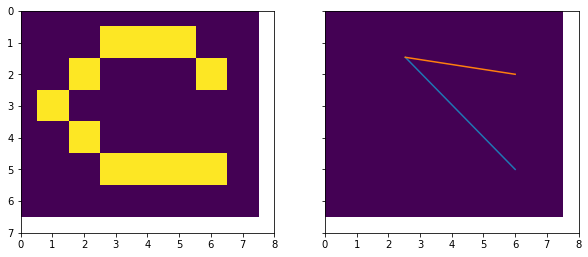

Length: 11.00, Waveiness: 0.9951 



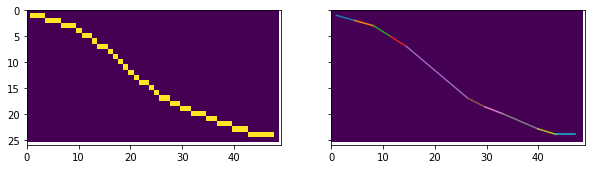

Length: 47.00, Waveiness: 0.3050 



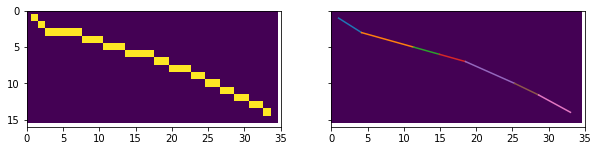

Length: 33.00, Waveiness: 0.3465 



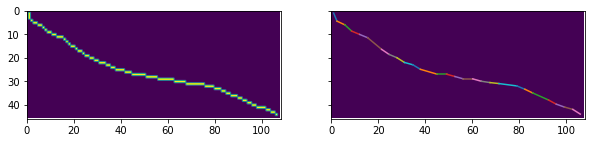

Length: 108.00, Waveiness: 0.3167 



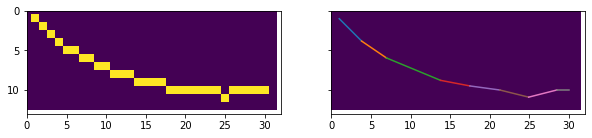

Length: 30.00, Waveiness: 0.3313 



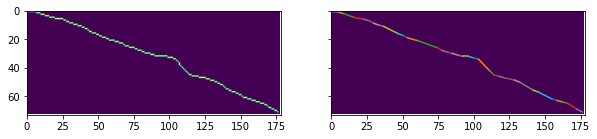

Length: 177.00, Waveiness: 0.3349 



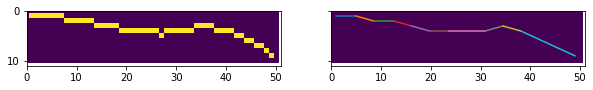

Length: 49.00, Waveiness: 0.3229 



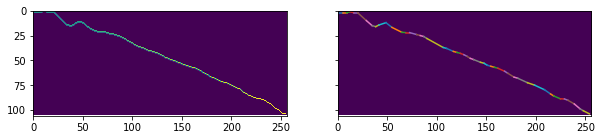

Length: 254.00, Waveiness: 0.3497 



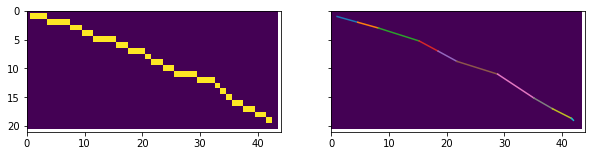

Length: 42.00, Waveiness: 0.3424 



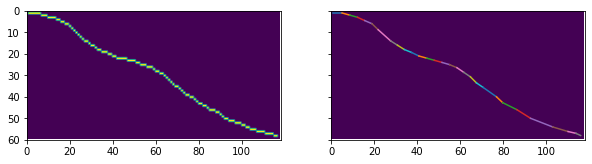

Length: 116.00, Waveiness: 0.2997 



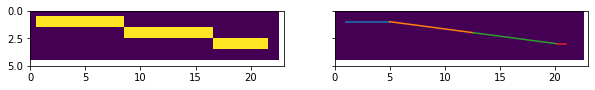

Length: 21.00, Waveiness: 0.1833 



In [42]:
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad( region.image, (1, 1) )
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length/seg_length))
    split_points = [int(i*seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
    if len(splitter) < 1: fragments = [shape_line]
    else: fragments = split(shape_line, splitter)
    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image* 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))
    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waveiness: {waviness:.4f} \n')

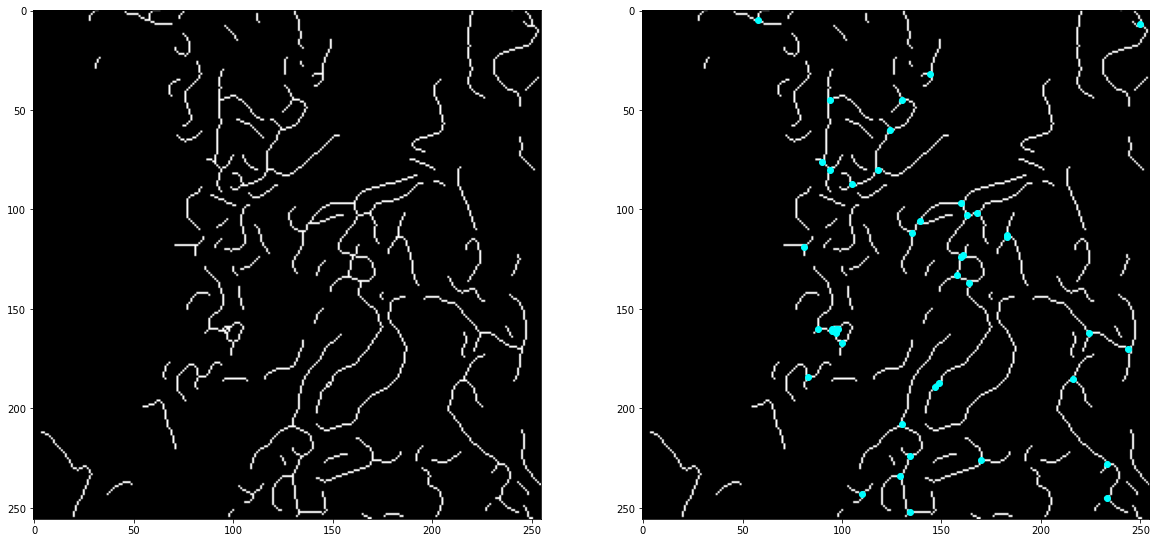

{'cir_mean': 1.491340674814904, 'cir_var': 0.7704971215779296, 'len_mean': 21.26923076923077, 'len_var': 17.506169664759934, 'waviness': 0.4341205874514831, 'intensity': 2303, 'density': array([[0.        , 0.        , 0.        , ..., 0.06116024, 0.02508396,
        0.00865439],
       [0.        , 0.        , 0.        , ..., 0.10555211, 0.04712768,
        0.01755368],
       [0.        , 0.        , 0.        , ..., 0.16708804, 0.08016268,
        0.03196463],
       ...,
       [0.        , 0.        , 0.        , ..., 0.21893609, 0.10762466,
        0.04422553],
       [0.        , 0.        , 0.        , ..., 0.29810428, 0.1552889 ,
        0.06700552],
       [0.        , 0.        , 0.        , ..., 0.3734635 , 0.20243974,
        0.09022324]])}


In [43]:
# create centerline from masks
centerline = CenterLine(centerline_image=io.imread("0035584(0.252889)(3.531491).tif"))
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[1].imshow(filtered_image, cmap=plt.cm.gray)
ax[1].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline.compute_fiber_feats()
print(centerline.feats)

In [53]:
### Process a batch of images with ridge detector
img_fnames = glob('annotations/coarse_ridge/images/*.tif')
masks_dir = 'annotations/coarse_ridge/masks'
labels_dir = 'annotations/coarse_ridge/labels'
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
for img_fname in img_fnames:
    centerline_ridge = CenterLine(associate_image=io.imread(img_fname))
    line_dict = centerline_ridge.ridge_detector(config_fname="ridge_detector_params.json")
    centerline_ridge = CenterLine(line_dict=line_dict, associate_image=io.imread(img_fname))
    img_name = os.path.splitext(img_fname.split(os.sep)[-1])[0]
    csv_fname = os.path.join(labels_dir, img_name+'.csv')
    masks_fname = os.path.join(masks_dir, img_name+'.tif')
    centerline_ridge.export_line_dict(csv_fname)
    io.imsave(masks_fname, centerline_ridge.centerline_image)

At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Best___X01Y05___4_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Best___X06Y07___5_4.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core147_fused-1-G2___0_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core147_fused-1-G2___0_2.tif is a low contrast image
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core164_fused-1-G3___0_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core1_fused-1-G2___1_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core41_fused-2-G3___0_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core41_fused-2-G3___0_1.tif is a low contrast image
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core81_fused-1-G3___0_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core81_fused-1-G3___0_0.tif is a low contrast image
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Cole___core91_fused-1-G2___1_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_B1___1_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_B9___1_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_C3___1_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_D3___0_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_D9___1_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_E5___2_3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_F3___2_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_G8___1_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_I6___1_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_J2___1_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_J5___3_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_J6___3_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___1B_L1___1_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_A2___3_3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_A5___1_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_B1___2_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_B7___2_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_C3___2_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_D5___1_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_D9___2_3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\JPI___2B_G3___1_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_003_a-lsm--12157_10338.ome___2_6.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_003_a-lsm--16382_8206.ome___3_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_003_a-lsm--16382_8206.ome___3_2.tif is a low contrast image
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_040-lsm--13230_7985.ome___2_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_074-lsm--5717_3881.ome___0_0.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_088-lsm--19034_5480.ome___4_3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_090-lsm--5863_14426.ome___3_4.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_137-lsm--7738_4325.ome___5_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_N302L5-lsm--18668_7715.ome___1_3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\PCCP___PDAC_MetroHealth_N358L47-lsm--13856_8605.ome___3_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained-lsm--D-9.ome___3_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained-lsm--G-7.ome___2_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained-lsm--K-12.ome___3_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained-lsm--K-3.ome___2_1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained_part2-lsm--A-13.ome___4_4.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained_part2-lsm--F-17.ome___1_2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained_part2-lsm--F-17.ome___1_2.tif is a low contrast image
  io.imsave(masks_fname, centerline_ridge.centerline_image)


At least one of centerline_image, line_dict, and dataframe should be provided.


C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\2625837842.py:15: UserWarning: annotations/coarse_ridge/masks\Unstained___PDAC.3.A_Unstained_part2-lsm--I-16.ome___2_4.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)


In [57]:
### Process a batch of mat files produced by ctFIRE
mat_fnames = glob('annotations/coarse_ctFIRE/mats/*.mat')
masks_dir = 'annotations/coarse_ctFIRE/masks'
labels_dir = 'annotations/coarse_ctFIRE/labels'
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
for mat_fname in mat_fnames:
    centerline_mat = CenterLine()
    mat = sio.loadmat(mat_fname)
    mat_data = mat['data']
    line_dict = centerline_mat.mat_to_lines(mat_data=mat_data)
    centerline_mat = CenterLine(line_dict=line_dict)
    img_name = os.path.splitext(mat_fname.split(os.sep)[-1])[0].split('ctFIREout_')[-1]
    csv_fname = os.path.join(labels_dir, img_name+'.csv')
    masks_fname = os.path.join(masks_dir, img_name+'.tif')
    centerline_mat.export_line_dict(csv_fname)
    io.imsave(masks_fname, img_as_ubyte(centerline_mat.centerline_image))

At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dataframe should be provided.
At least one of centerline_image, line_dict, and dat

In [61]:
### Process a batch of annotations and generate the masks
csv_fnames = glob('annotations/round_2/labels/*.csv')
masks_dir = 'annotations/round_2/masks'
labels_dir = 'annotations/round_2/labels'
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
for csv_fname in csv_fnames:
    centerline_ridge = CenterLine(dataframe=pd.read_csv(csv_fname, index_col=0))
    img_name = os.path.splitext(csv_fname.split(os.sep)[-1])[0]
    masks_fname = os.path.join(masks_dir, img_name+'.tif')
    io.imsave(masks_fname, centerline_ridge.centerline_image)

C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\3360364695.py:11: UserWarning: annotations/round_2/masks\Best___X02Y08___1_3_points.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\3360364695.py:11: UserWarning: annotations/round_2/masks\Best___X02Y08___1_3_points.tif is a low contrast image
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\3360364695.py:11: UserWarning: annotations/round_2/masks\Best___X21Y03___1_2_points.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(masks_fname, centerline_ridge.centerline_image)
C:\Users\bli346\AppData\Local\Temp\ipykernel_43588\3360364695.py:11: UserWarning: annotations/round_2/masks\Cole___core147_fuse

### Measure the similarity of two centerline (masks)

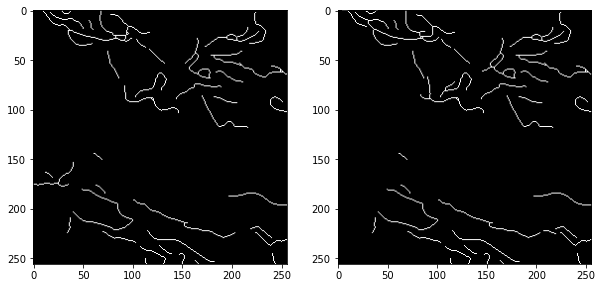

In [17]:
### any two centerline masks
image_1 = io.imread('Michael.tif')
image_2 = io.imread('Bin.tif')
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_1, cmap='gray')
ax[1].imshow(image_2, cmap='gray')

0.9228023152549197


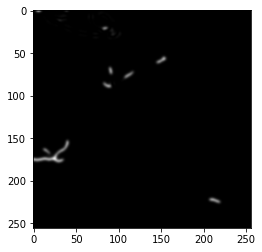

In [18]:
### Pixel-level metrics, soft IoU
ratio, U, I = iou(smooth_mask(image_1), smooth_mask(image_2), soft=True)
plt.imshow(U-I, cmap='gray')
print(np.sum(I)/np.sum(U))

In [ ]:
### cosine similarity of the features, maybe need to normalize each feature throughout the testing set

## Evaluation

In [7]:
from skimage import filters
from skimage import morphology

In [80]:
raw_nw_fnames = glob('evaluations/pilot/network-output/resTe/*_Lpred.png')
raw_input_fnames = glob('evaluations/pilot/network-output/resTe/*_I.png')
raw_target_fnames = glob('evaluations/pilot/network-output/resTe/*_Ltrue.png')

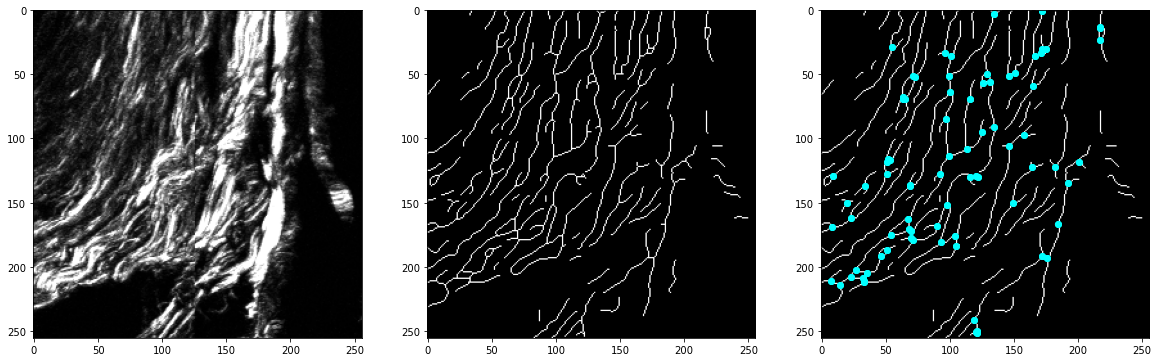

Network results:
{'cir_mean': -1.022962829945675, 'cir_var': 0.3564557310838169, 'len_mean': 26.282258064516128, 'len_var': 22.527961293966104, 'waviness': 0.3138773605712201, 'intensity': 3376, 'density': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


In [81]:
# vectorization using skimage skeletonization
img = img_as_float( io.imread( raw_nw_fnames[1] ))
binary = img > filters.threshold_mean((img))
binary = morphology.skeletonize(binary)
centerline_res = CenterLine(centerline_image=binary, associate_image=io.imread(raw_input_fnames[1]))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(centerline_res.feats)

At least one of centerline_image, line_dict, and dataframe should be provided.


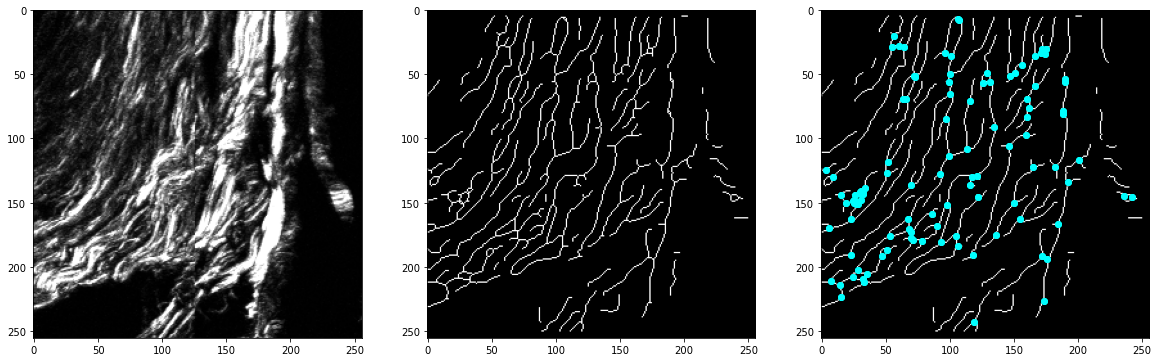

Network results:
{'cir_mean': -0.9633227828645726, 'cir_var': 0.3448769149450074, 'len_mean': 24.625, 'len_var': 20.527577397820945, 'waviness': 0.3803477267206668, 'intensity': 3507, 'density': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


In [82]:
# vectorization using ridge detector
img = img_as_float( io.imread( raw_nw_fnames[1] ))
binary = img > filters.threshold_mean((img))
centerline_res = CenterLine(associate_image=binary)
line_dict = centerline_res.ridge_detector(config_fname="ridge_detector_params.json")
centerline_res = CenterLine(line_dict=line_dict, associate_image=io.imread(raw_input_fnames[1]))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(centerline_res.feats)

At least one of centerline_image, line_dict, and dataframe should be provided.


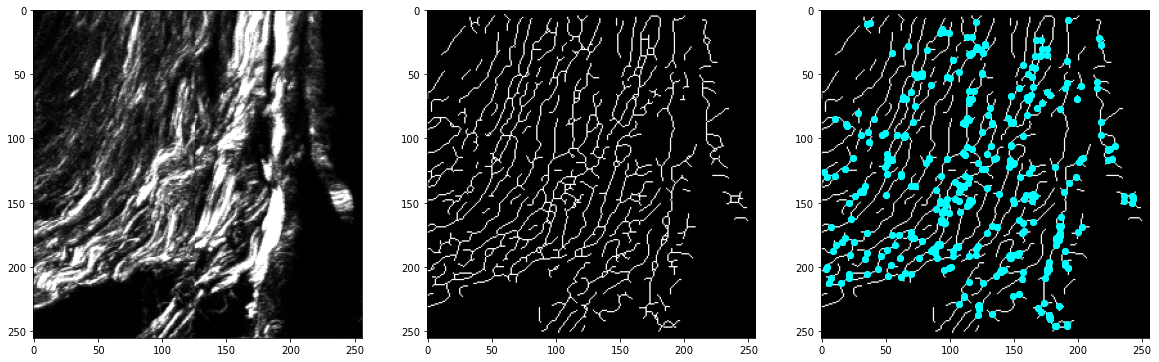

Ridge detector:
{'cir_mean': -1.2633221616634853, 'cir_var': 0.49587979414961847, 'len_mean': 17.108949416342412, 'len_var': 13.969804765986385, 'waviness': 0.42982073992790687, 'intensity': 5063, 'density': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


In [83]:
# Ridge detector
centerline_ridge = CenterLine(associate_image=io.imread(raw_input_fnames[1]))
line_dict = centerline_ridge.ridge_detector(config_fname="ridge_detector_params.json")
centerline_ridge = CenterLine(line_dict=line_dict, associate_image=io.imread(raw_input_fnames[1]))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_ridge.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_ridge.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_ridge.joint_filter(centerline_ridge.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Ridge detector:')
centerline_ridge.compute_fiber_feats()
print(centerline_ridge.feats)

At least one of centerline_image, line_dict, and dataframe should be provided.


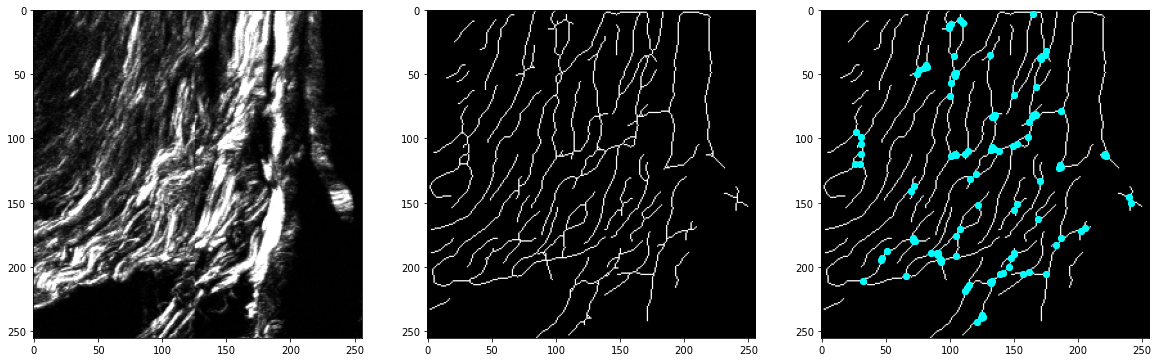

ctFIRE
{'cir_mean': -0.996035200079854, 'cir_var': 0.41528459367399667, 'len_mean': 32.16831683168317, 'len_var': 36.926490881887396, 'waviness': 0.3393319018876907, 'intensity': 3419, 'density': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


In [87]:
# ctFIRE
mat = sio.loadmat('evaluations/pilot/ctFIRE_dir/ctFIREout/ctFIREout_100_I.mat')
mat_data = mat['data']
centerline_mat = CenterLine()
line_dict = centerline_mat.mat_to_lines(mat_data)
centerline_mat = CenterLine(line_dict=line_dict, associate_image=io.imread(raw_input_fnames[1]))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_mat.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_mat.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_mat.joint_filter(centerline_mat.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('ctFIRE')
centerline_mat.compute_fiber_feats()
print(centerline_mat.feats)

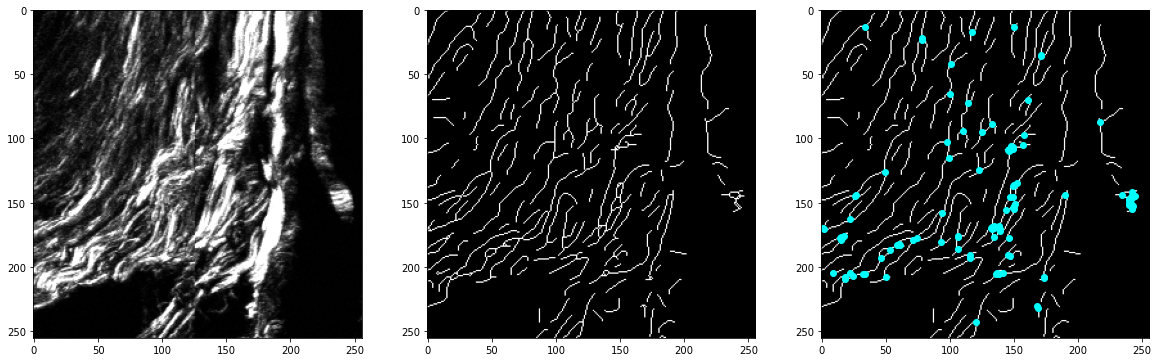

Ground truth:
{'cir_mean': -1.0520142564726411, 'cir_var': 0.2835704627748545, 'len_mean': 21.503067484662576, 'len_var': 17.317098268215393, 'waviness': 0.33906066682924535, 'intensity': 3672, 'density': array([[6.74142771e-07, 4.47780135e-06, 2.42341014e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.76423714e-06, 2.20550579e-05, 1.05640781e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.74020348e-05, 9.14316327e-05, 3.94308326e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])}


In [85]:
# Ground truth
centerline = CenterLine(centerline_image=io.imread(raw_target_fnames[1]), associate_image=io.imread(raw_input_fnames[1]))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Ground truth:')
centerline.compute_fiber_feats()
print(centerline.feats)

0.5756760035387165


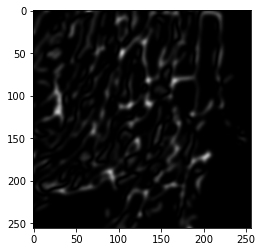

In [119]:
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_mat.centerline_image), soft=True)
plt.imshow(U-I, cmap='gray')
print(ratio)

0.6702952757028613


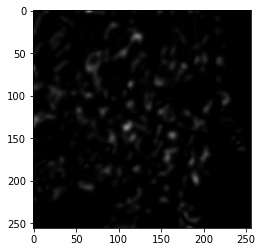

In [120]:
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_ridge.centerline_image), soft=True)
plt.imshow(U-I, cmap='gray')
print(ratio)

0.6311294512822581


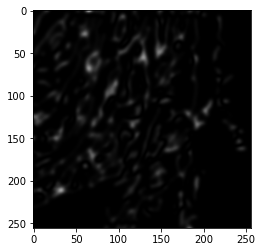

In [121]:
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_res.centerline_image), soft=True)
plt.imshow(U-I, cmap='gray')
print(ratio)